In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models
import torch.nn.functional as F

In [2]:
import warnings
warnings.filterwarnings('ignore')

Files already downloaded and verified
Accuracy of resnet152_cifar100 on the 10000 test images: 61.96%
Bin 1 (range: 0.00-0.02):
  Total images: 0.0
  Correctly classified: 0.0
Bin 2 (range: 0.02-0.04):
  Total images: 0.0
  Correctly classified: 0.0
Bin 3 (range: 0.04-0.06):
  Total images: 0.0
  Correctly classified: 0.0
Bin 4 (range: 0.06-0.08):
  Total images: 0.0
  Correctly classified: 0.0
Bin 5 (range: 0.08-0.10):
  Total images: 1.0
  Correctly classified: 0.0
Bin 6 (range: 0.10-0.12):
  Total images: 5.0
  Correctly classified: 0.0
Bin 7 (range: 0.12-0.14):
  Total images: 16.0
  Correctly classified: 2.0
Bin 8 (range: 0.14-0.16):
  Total images: 21.0
  Correctly classified: 3.0
Bin 9 (range: 0.16-0.18):
  Total images: 47.0
  Correctly classified: 5.0
Bin 10 (range: 0.18-0.20):
  Total images: 49.0
  Correctly classified: 5.0
Bin 11 (range: 0.20-0.22):
  Total images: 80.0
  Correctly classified: 12.0
Bin 12 (range: 0.22-0.24):
  Total images: 76.0
  Correctly classified: 14.0

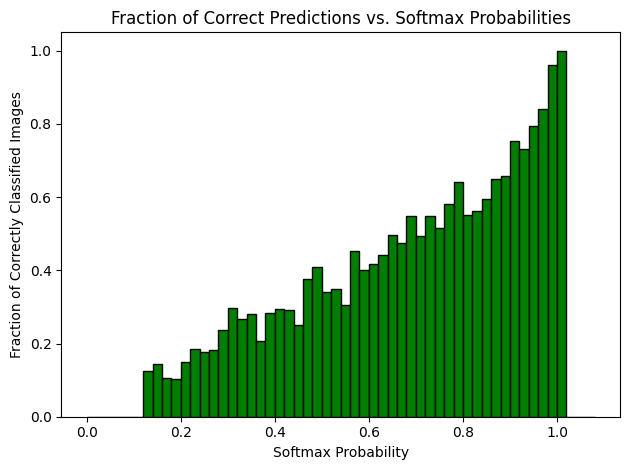

In [14]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
batch_size = 100

# Data preprocessing
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762)),
])

# CIFAR-100 dataset
test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Load the model
model = models.resnet152(pretrained=False)  # pretrained=False as you are loading trained weights
model.fc = torch.nn.Linear(model.fc.in_features, 100)  # CIFAR-100 has 100 classes
model.load_state_dict(torch.load('/kaggle/input/resnet152_cifar100/pytorch/default/1/resnet152_cifar100.pth', map_location=device))

# Move the model to the appropriate device
model = model.to(device)
model.eval()

# Prepare to store results
prob_bins = np.arange(0, 1.1, 0.02)  # Bins for softmax probabilities (0.0 to 1.0 in intervals of 0.08)
correct_count = np.zeros(len(prob_bins) - 1)  # Array to hold correct predictions count for each bin
incorrect_count = np.zeros(len(prob_bins) - 1)
total_count = np.zeros(len(prob_bins) - 1)  # Array to hold the total number of images per bin

# Initialize counters for accuracy
correct = 0
incorrect = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Get model outputs and softmax probabilities
        outputs = model(images)
        softmax_probs = F.softmax(outputs, dim=1)
        
        # Get predicted classes and their associated probabilities
        predicted_probs, predicted_labels = torch.max(softmax_probs, dim=1)

        # Check which predictions are correct
        correct_predictions = (predicted_labels == labels)
        incorrect_predictions = (predicted_labels != labels)
        
        # Update the accuracy counters
        total += labels.size(0)
        correct += correct_predictions.sum().item()
        incorrect += incorrect_predictions.sum().item()

        # Iterate over each image in the batch
        for i in range(images.size(0)):
            prob = predicted_probs[i].item()
            is_correct = correct_predictions[i].item()
            is_incorrect = incorrect_predictions[i].item()

            # Find which bin the probability belongs to
            bin_idx = np.digitize(prob, prob_bins) - 1  # Adjust for 0-indexing

            # Ensure bin index is within valid range
            bin_idx = min(bin_idx, len(total_count) - 1)

            # Increment the total count for the bin
            total_count[bin_idx] += 1

            # Increment correct/incorrect counts based on prediction
            if is_correct:
                correct_count[bin_idx] += 1
            if is_incorrect:
                incorrect_count[bin_idx] += 1

# Calculate accuracy per bin (fraction of correct predictions in each bin)
fraction_correct = correct_count / total_count
fraction_correct[np.isnan(fraction_correct)] = 0  # Handle division by zero

# Calculate and print overall accuracy
accuracy = 100 * correct / total
print(f'Accuracy of resnet152_cifar100 on the 10000 test images: {accuracy:.2f}%')

# Print number of images in each bin and number of correctly classified images in each bin
for i in range(len(total_count)):
    print(f'Bin {i+1} (range: {prob_bins[i]:.2f}-{prob_bins[i+1]:.2f}):')
    print(f'  Total images: {total_count[i]}')
    print(f'  Correctly classified: {correct_count[i]}')

# Plotting the results
bin_centers = 0.5 * (prob_bins[:-1] + prob_bins[1:])  # Calculate bin centers for plotting
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# First subplot for fraction of correct classifications
plt.bar(bin_centers, fraction_correct, width=0.02, color='g', edgecolor='black')
plt.xlabel('Softmax Probability')
plt.ylabel('Fraction of Correctly Classified Images')
plt.title('Fraction of Correct Predictions vs. Softmax Probabilities')

# Second subplot for total number of images per bin
# plt.set_xlabel('Softmax Probability')
# plt.set_ylabel('Number of Images')
# plt.set_title('Total Number of Images per Softmax Probability Bin')

# Display the plots
plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Total Number of Images')

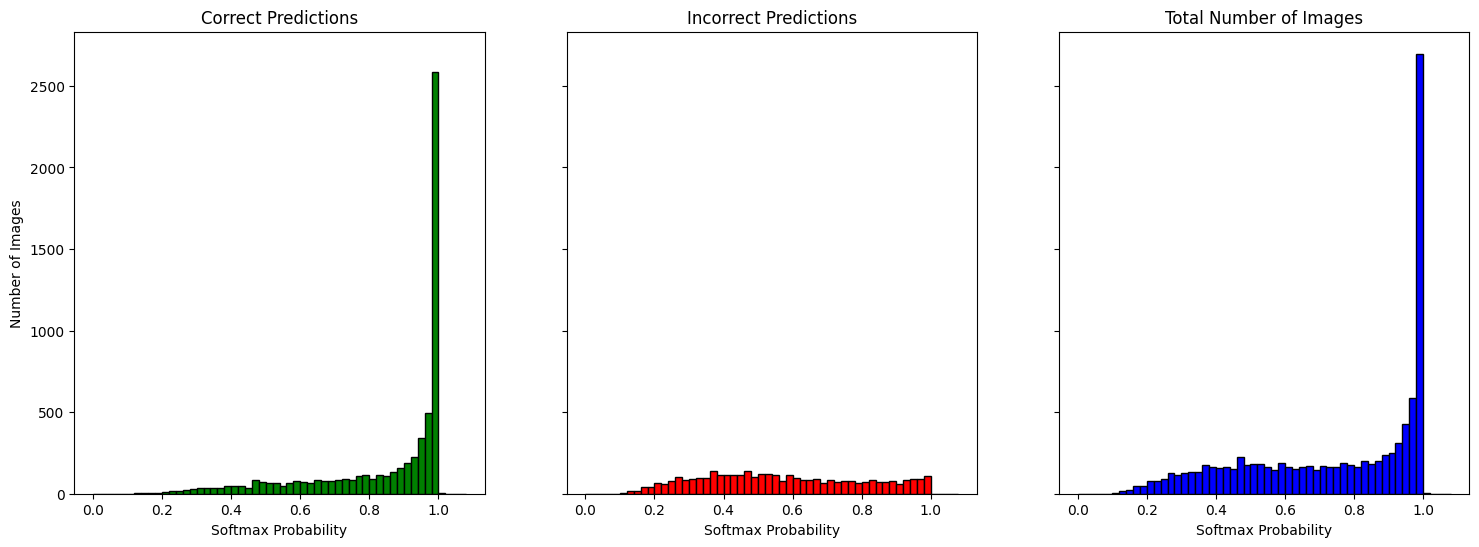

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# First subplot for the number of correct classifications
ax1.bar(bin_centers, correct_count, width=0.02, color='g', edgecolor='black')
ax1.set_xlabel('Softmax Probability')
ax1.set_ylabel('Number of Images')
ax1.set_title('Correct Predictions')

# Second subplot for the number of incorrect classifications
ax2.bar(bin_centers, incorrect_count, width=0.02, color='r', edgecolor='black')
ax2.set_xlabel('Softmax Probability')
ax2.set_title('Incorrect Predictions')

# Third subplot for the total number of images per bin
ax3.bar(bin_centers, total_count, width=0.02, color='b', edgecolor='black')
ax3.set_xlabel('Softmax Probability')
ax3.set_title('Total Number of Images')

Files already downloaded and verified
Accuracy of resnet152_cifar100 on the 10000 test images: 61.96%
Bin 1 (range: 0.00-0.08):
  Total images: 0.0
  Correctly classified: 0.0
Bin 2 (range: 0.08-0.16):
  Total images: 43.0
  Correctly classified: 5.0
Bin 3 (range: 0.16-0.24):
  Total images: 252.0
  Correctly classified: 36.0
Bin 4 (range: 0.24-0.32):
  Total images: 457.0
  Correctly classified: 103.0
Bin 5 (range: 0.32-0.40):
  Total images: 603.0
  Correctly classified: 155.0
Bin 6 (range: 0.40-0.48):
  Total images: 701.0
  Correctly classified: 218.0
Bin 7 (range: 0.48-0.56):
  Total images: 703.0
  Correctly classified: 247.0
Bin 8 (range: 0.56-0.64):
  Total images: 650.0
  Correctly classified: 277.0
Bin 9 (range: 0.64-0.72):
  Total images: 646.0
  Correctly classified: 324.0
Bin 10 (range: 0.72-0.80):
  Total images: 688.0
  Correctly classified: 395.0
Bin 11 (range: 0.80-0.88):
  Total images: 749.0
  Correctly classified: 443.0
Bin 12 (range: 0.88-0.96):
  Total images: 122

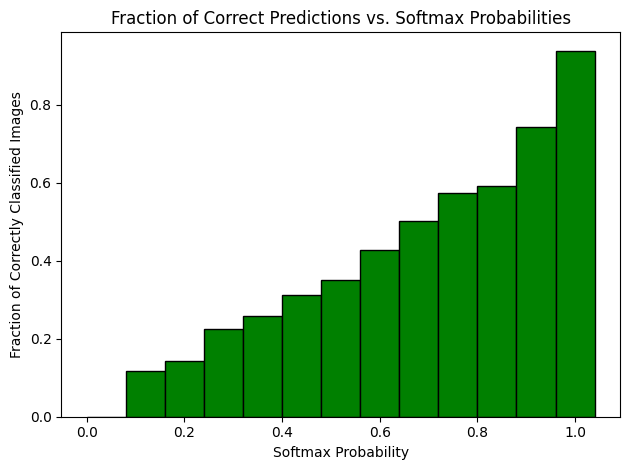

In [22]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
batch_size = 100

# Data preprocessing
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762)),
])

# CIFAR-100 dataset
test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Load the model
model = models.resnet152(pretrained=False)  # pretrained=False as you are loading trained weights
model.fc = torch.nn.Linear(model.fc.in_features, 100)  # CIFAR-100 has 100 classes
model.load_state_dict(torch.load('/kaggle/input/resnet152_cifar100/pytorch/default/1/resnet152_cifar100.pth', map_location=device))

# Move the model to the appropriate device
model = model.to(device)
model.eval()

# Prepare to store results
prob_bins = np.arange(0, 1.1, 0.08)  # Bins for softmax probabilities (0.0 to 1.0 in intervals of 0.08)
correct_count = np.zeros(len(prob_bins) - 1)  # Array to hold correct predictions count for each bin
incorrect_count = np.zeros(len(prob_bins) - 1)
total_count = np.zeros(len(prob_bins) - 1)  # Array to hold the total number of images per bin

# Initialize counters for accuracy
correct = 0
incorrect = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Get model outputs and softmax probabilities
        outputs = model(images)
        softmax_probs = F.softmax(outputs, dim=1)
        
        # Get predicted classes and their associated probabilities
        predicted_probs, predicted_labels = torch.max(softmax_probs, dim=1)

        # Check which predictions are correct
        correct_predictions = (predicted_labels == labels)
        incorrect_predictions = (predicted_labels != labels)
        
        # Update the accuracy counters
        total += labels.size(0)
        correct += correct_predictions.sum().item()
        incorrect += incorrect_predictions.sum().item()

        # Iterate over each image in the batch
        for i in range(images.size(0)):
            prob = predicted_probs[i].item()
            is_correct = correct_predictions[i].item()
            is_incorrect = incorrect_predictions[i].item()

            # Find which bin the probability belongs to
            bin_idx = np.digitize(prob, prob_bins) - 1  # Adjust for 0-indexing

            # Ensure bin index is within valid range
            bin_idx = min(bin_idx, len(total_count) - 1)

            # Increment the total count for the bin
            total_count[bin_idx] += 1

            # Increment correct/incorrect counts based on prediction
            if is_correct:
                correct_count[bin_idx] += 1
            if is_incorrect:
                incorrect_count[bin_idx] += 1

# Calculate accuracy per bin (fraction of correct predictions in each bin)
fraction_correct = correct_count / total_count
fraction_correct[np.isnan(fraction_correct)] = 0  # Handle division by zero

# Calculate and print overall accuracy
accuracy = 100 * correct / total
print(f'Accuracy of resnet152_cifar100 on the 10000 test images: {accuracy:.2f}%')

# Print number of images in each bin and number of correctly classified images in each bin
for i in range(len(total_count)):
    print(f'Bin {i+1} (range: {prob_bins[i]:.2f}-{prob_bins[i+1]:.2f}):')
    print(f'  Total images: {total_count[i]}')
    print(f'  Correctly classified: {correct_count[i]}')

# Plotting the results
bin_centers = 0.5 * (prob_bins[:-1] + prob_bins[1:])  # Calculate bin centers for plotting
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# First subplot for fraction of correct classifications
plt.bar(bin_centers, fraction_correct, width=0.08, color='g', edgecolor='black')
plt.xlabel('Softmax Probability')
plt.ylabel('Fraction of Correctly Classified Images')
plt.title('Fraction of Correct Predictions vs. Softmax Probabilities')

# Second subplot for total number of images per bin
# plt.set_xlabel('Softmax Probability')
# plt.set_ylabel('Number of Images')
# plt.set_title('Total Number of Images per Softmax Probability Bin')

# Display the plots
plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Total Number of Images')

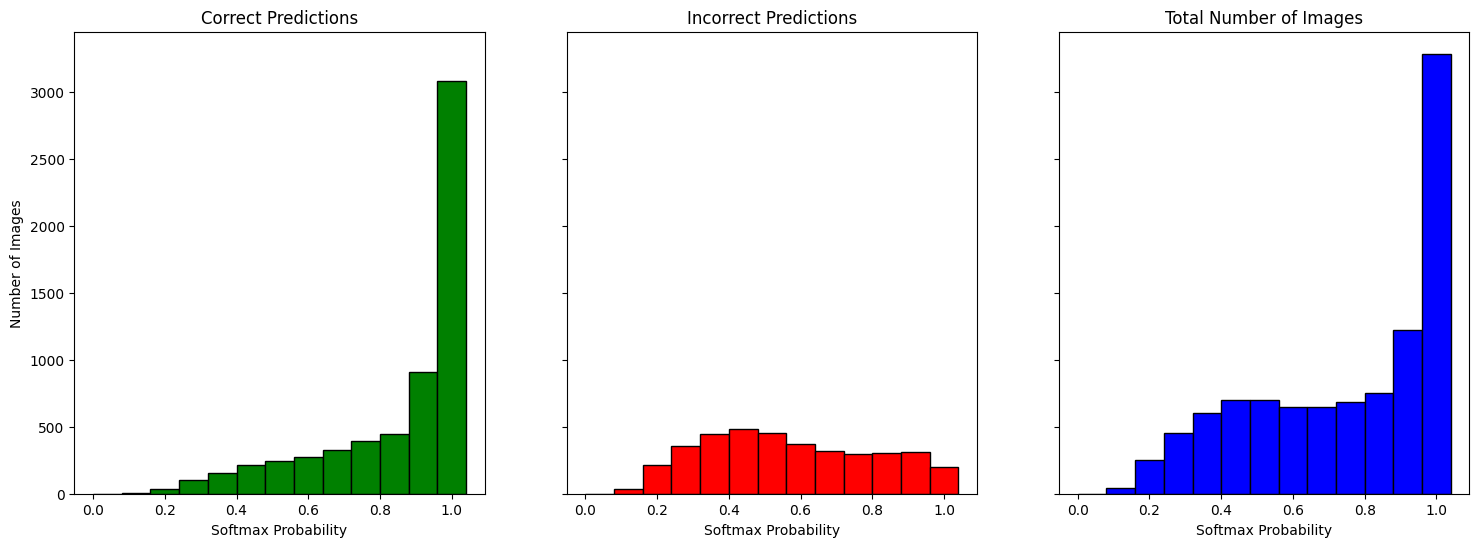

In [23]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# First subplot for the number of correct classifications
ax1.bar(bin_centers, correct_count, width=0.08, color='g', edgecolor='black')
ax1.set_xlabel('Softmax Probability')
ax1.set_ylabel('Number of Images')
ax1.set_title('Correct Predictions')

# Second subplot for the number of incorrect classifications
ax2.bar(bin_centers, incorrect_count, width=0.08, color='r', edgecolor='black')
ax2.set_xlabel('Softmax Probability')
ax2.set_title('Incorrect Predictions')

# Third subplot for the total number of images per bin
ax3.bar(bin_centers, total_count, width=0.08, color='b', edgecolor='black')
ax3.set_xlabel('Softmax Probability')
ax3.set_title('Total Number of Images')

Files already downloaded and verified
Accuracy of resnet101_cifar100 on the 10000 test images: 60.78%
Bin 1 (range: 0.00-0.08):
  Total images: 0.0
  Correctly classified: 0.0
Bin 2 (range: 0.08-0.16):
  Total images: 69.0
  Correctly classified: 7.0
Bin 3 (range: 0.16-0.24):
  Total images: 274.0
  Correctly classified: 37.0
Bin 4 (range: 0.24-0.32):
  Total images: 471.0
  Correctly classified: 91.0
Bin 5 (range: 0.32-0.40):
  Total images: 642.0
  Correctly classified: 160.0
Bin 6 (range: 0.40-0.48):
  Total images: 752.0
  Correctly classified: 223.0
Bin 7 (range: 0.48-0.56):
  Total images: 736.0
  Correctly classified: 283.0
Bin 8 (range: 0.56-0.64):
  Total images: 694.0
  Correctly classified: 295.0
Bin 9 (range: 0.64-0.72):
  Total images: 653.0
  Correctly classified: 315.0
Bin 10 (range: 0.72-0.80):
  Total images: 701.0
  Correctly classified: 406.0
Bin 11 (range: 0.80-0.88):
  Total images: 787.0
  Correctly classified: 508.0
Bin 12 (range: 0.88-0.96):
  Total images: 1071

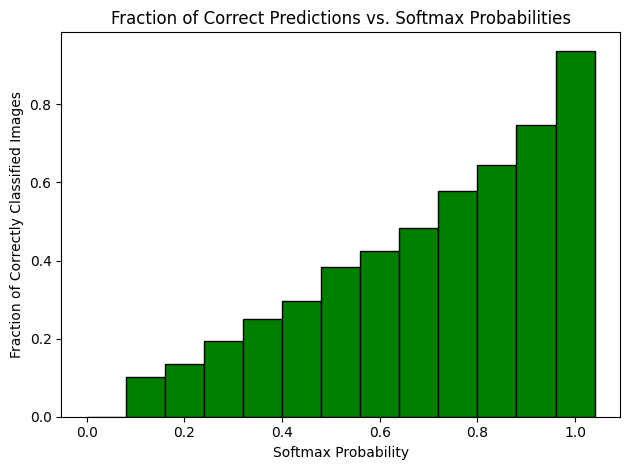

In [24]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
batch_size = 100

# Data preprocessing
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762)),
])

# CIFAR-100 dataset
test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Load the model
model = models.resnet101(pretrained=False)  # pretrained=False as you are loading trained weights
model.fc = torch.nn.Linear(model.fc.in_features, 100)  # CIFAR-100 has 100 classes
model.load_state_dict(torch.load('/kaggle/input/resnet101_cifar-100/pytorch/default/1/resnet101_cifar100.pth', map_location=device))

# Move the model to the appropriate device
model = model.to(device)
model.eval()

# Prepare to store results
prob_bins = np.arange(0, 1.1, 0.08)  # Bins for softmax probabilities (0.0 to 1.0 in intervals of 0.08)
correct_count = np.zeros(len(prob_bins) - 1)  # Array to hold correct predictions count for each bin
incorrect_count = np.zeros(len(prob_bins) - 1)
total_count = np.zeros(len(prob_bins) - 1)  # Array to hold the total number of images per bin

# Initialize counters for accuracy
correct = 0
incorrect = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Get model outputs and softmax probabilities
        outputs = model(images)
        softmax_probs = F.softmax(outputs, dim=1)
        
        # Get predicted classes and their associated probabilities
        predicted_probs, predicted_labels = torch.max(softmax_probs, dim=1)

        # Check which predictions are correct
        correct_predictions = (predicted_labels == labels)
        incorrect_predictions = (predicted_labels != labels)
        
        # Update the accuracy counters
        total += labels.size(0)
        correct += correct_predictions.sum().item()
        incorrect += incorrect_predictions.sum().item()

        # Iterate over each image in the batch
        for i in range(images.size(0)):
            prob = predicted_probs[i].item()
            is_correct = correct_predictions[i].item()
            is_incorrect = incorrect_predictions[i].item()

            # Find which bin the probability belongs to
            bin_idx = np.digitize(prob, prob_bins) - 1  # Adjust for 0-indexing

            # Ensure bin index is within valid range
            bin_idx = min(bin_idx, len(total_count) - 1)

            # Increment the total count for the bin
            total_count[bin_idx] += 1

            # Increment correct/incorrect counts based on prediction
            if is_correct:
                correct_count[bin_idx] += 1
            if is_incorrect:
                incorrect_count[bin_idx] += 1

# Calculate accuracy per bin (fraction of correct predictions in each bin)
fraction_correct = correct_count / total_count
fraction_correct[np.isnan(fraction_correct)] = 0  # Handle division by zero

# Calculate and print overall accuracy
accuracy = 100 * correct / total
print(f'Accuracy of resnet101_cifar100 on the 10000 test images: {accuracy:.2f}%')

# Print number of images in each bin and number of correctly classified images in each bin
for i in range(len(total_count)):
    print(f'Bin {i+1} (range: {prob_bins[i]:.2f}-{prob_bins[i+1]:.2f}):')
    print(f'  Total images: {total_count[i]}')
    print(f'  Correctly classified: {correct_count[i]}')

# Plotting the results
bin_centers = 0.5 * (prob_bins[:-1] + prob_bins[1:])  # Calculate bin centers for plotting
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# First subplot for fraction of correct classifications
plt.bar(bin_centers, fraction_correct, width=0.08, color='g', edgecolor='black')
plt.xlabel('Softmax Probability')
plt.ylabel('Fraction of Correctly Classified Images')
plt.title('Fraction of Correct Predictions vs. Softmax Probabilities')

# Second subplot for total number of images per bin
# plt.set_xlabel('Softmax Probability')
# plt.set_ylabel('Number of Images')
# plt.set_title('Total Number of Images per Softmax Probability Bin')

# Display the plots
plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Total Number of Images')

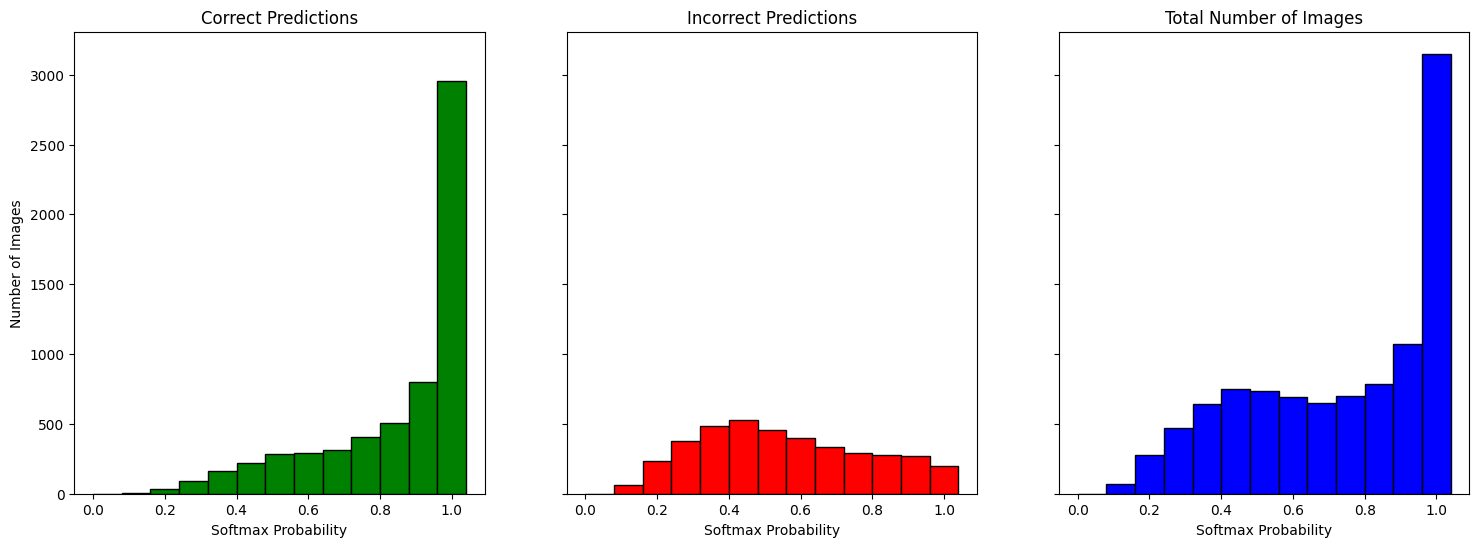

In [26]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# First subplot for the number of correct classifications
ax1.bar(bin_centers, correct_count, width=0.08, color='g', edgecolor='black')
ax1.set_xlabel('Softmax Probability')
ax1.set_ylabel('Number of Images')
ax1.set_title('Correct Predictions')

# Second subplot for the number of incorrect classifications
ax2.bar(bin_centers, incorrect_count, width=0.08, color='r', edgecolor='black')
ax2.set_xlabel('Softmax Probability')
ax2.set_title('Incorrect Predictions')

# Third subplot for the total number of images per bin
ax3.bar(bin_centers, total_count, width=0.08, color='b', edgecolor='black')
ax3.set_xlabel('Softmax Probability')
ax3.set_title('Total Number of Images')

Files already downloaded and verified
Accuracy of resnet101_cifar100 on the 10000 test images: 60.78%
Bin 1 (range: 0.00-0.02):
  Total images: 0.0
  Correctly classified: 0.0
Bin 2 (range: 0.02-0.04):
  Total images: 0.0
  Correctly classified: 0.0
Bin 3 (range: 0.04-0.06):
  Total images: 0.0
  Correctly classified: 0.0
Bin 4 (range: 0.06-0.08):
  Total images: 0.0
  Correctly classified: 0.0
Bin 5 (range: 0.08-0.10):
  Total images: 3.0
  Correctly classified: 1.0
Bin 6 (range: 0.10-0.12):
  Total images: 8.0
  Correctly classified: 2.0
Bin 7 (range: 0.12-0.14):
  Total images: 23.0
  Correctly classified: 1.0
Bin 8 (range: 0.14-0.16):
  Total images: 35.0
  Correctly classified: 3.0
Bin 9 (range: 0.16-0.18):
  Total images: 51.0
  Correctly classified: 8.0
Bin 10 (range: 0.18-0.20):
  Total images: 65.0
  Correctly classified: 10.0
Bin 11 (range: 0.20-0.22):
  Total images: 65.0
  Correctly classified: 7.0
Bin 12 (range: 0.22-0.24):
  Total images: 93.0
  Correctly classified: 12.0

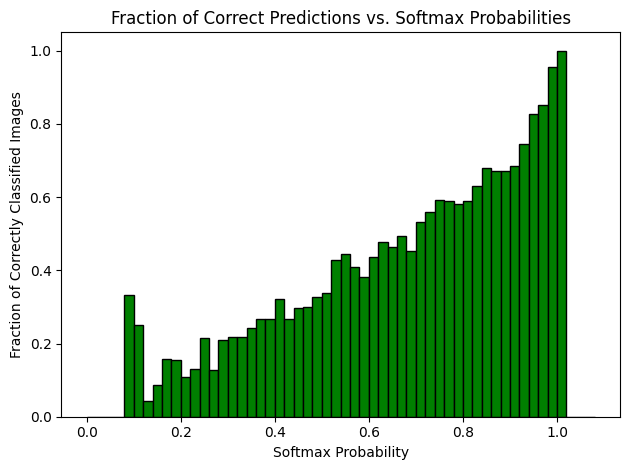

In [27]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
batch_size = 100

# Data preprocessing
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762)),
])

# CIFAR-100 dataset
test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Load the model
model = models.resnet101(pretrained=False)  # pretrained=False as you are loading trained weights
model.fc = torch.nn.Linear(model.fc.in_features, 100)  # CIFAR-100 has 100 classes
model.load_state_dict(torch.load('/kaggle/input/resnet101_cifar-100/pytorch/default/1/resnet101_cifar100.pth', map_location=device))

# Move the model to the appropriate device
model = model.to(device)
model.eval()

# Prepare to store results
prob_bins = np.arange(0, 1.1, 0.02)  # Bins for softmax probabilities (0.0 to 1.0 in intervals of 0.08)
correct_count = np.zeros(len(prob_bins) - 1)  # Array to hold correct predictions count for each bin
incorrect_count = np.zeros(len(prob_bins) - 1)
total_count = np.zeros(len(prob_bins) - 1)  # Array to hold the total number of images per bin

# Initialize counters for accuracy
correct = 0
incorrect = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Get model outputs and softmax probabilities
        outputs = model(images)
        softmax_probs = F.softmax(outputs, dim=1)
        
        # Get predicted classes and their associated probabilities
        predicted_probs, predicted_labels = torch.max(softmax_probs, dim=1)

        # Check which predictions are correct
        correct_predictions = (predicted_labels == labels)
        incorrect_predictions = (predicted_labels != labels)
        
        # Update the accuracy counters
        total += labels.size(0)
        correct += correct_predictions.sum().item()
        incorrect += incorrect_predictions.sum().item()

        # Iterate over each image in the batch
        for i in range(images.size(0)):
            prob = predicted_probs[i].item()
            is_correct = correct_predictions[i].item()
            is_incorrect = incorrect_predictions[i].item()

            # Find which bin the probability belongs to
            bin_idx = np.digitize(prob, prob_bins) - 1  # Adjust for 0-indexing

            # Ensure bin index is within valid range
            bin_idx = min(bin_idx, len(total_count) - 1)

            # Increment the total count for the bin
            total_count[bin_idx] += 1

            # Increment correct/incorrect counts based on prediction
            if is_correct:
                correct_count[bin_idx] += 1
            if is_incorrect:
                incorrect_count[bin_idx] += 1

# Calculate accuracy per bin (fraction of correct predictions in each bin)
fraction_correct = correct_count / total_count
fraction_correct[np.isnan(fraction_correct)] = 0  # Handle division by zero

# Calculate and print overall accuracy
accuracy = 100 * correct / total
print(f'Accuracy of resnet101_cifar100 on the 10000 test images: {accuracy:.2f}%')

# Print number of images in each bin and number of correctly classified images in each bin
for i in range(len(total_count)):
    print(f'Bin {i+1} (range: {prob_bins[i]:.2f}-{prob_bins[i+1]:.2f}):')
    print(f'  Total images: {total_count[i]}')
    print(f'  Correctly classified: {correct_count[i]}')

# Plotting the results
bin_centers = 0.5 * (prob_bins[:-1] + prob_bins[1:])  # Calculate bin centers for plotting
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# First subplot for fraction of correct classifications
plt.bar(bin_centers, fraction_correct, width=0.02, color='g', edgecolor='black')
plt.xlabel('Softmax Probability')
plt.ylabel('Fraction of Correctly Classified Images')
plt.title('Fraction of Correct Predictions vs. Softmax Probabilities')

# Second subplot for total number of images per bin
# plt.set_xlabel('Softmax Probability')
# plt.set_ylabel('Number of Images')
# plt.set_title('Total Number of Images per Softmax Probability Bin')

# Display the plots
plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Total Number of Images')

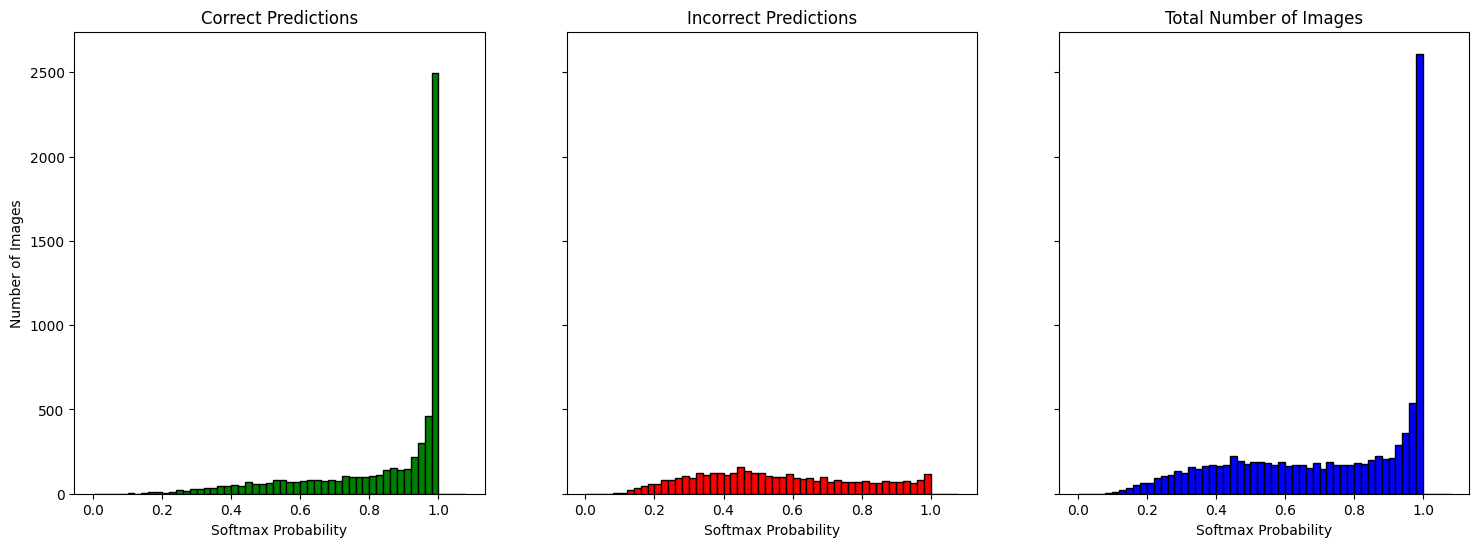

In [28]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# First subplot for the number of correct classifications
ax1.bar(bin_centers, correct_count, width=0.02, color='g', edgecolor='black')
ax1.set_xlabel('Softmax Probability')
ax1.set_ylabel('Number of Images')
ax1.set_title('Correct Predictions')

# Second subplot for the number of incorrect classifications
ax2.bar(bin_centers, incorrect_count, width=0.02, color='r', edgecolor='black')
ax2.set_xlabel('Softmax Probability')
ax2.set_title('Incorrect Predictions')

# Third subplot for the total number of images per bin
ax3.bar(bin_centers, total_count, width=0.02, color='b', edgecolor='black')
ax3.set_xlabel('Softmax Probability')
ax3.set_title('Total Number of Images')

Files already downloaded and verified
Accuracy of resnet50_cifar100 on the 10000 test images: 51.15%
Bin 1 (range: 0.00-0.08):
  Total images: 3.0
  Correctly classified: 0.0
Bin 2 (range: 0.08-0.16):
  Total images: 337.0
  Correctly classified: 46.0
Bin 3 (range: 0.16-0.24):
  Total images: 926.0
  Correctly classified: 147.0
Bin 4 (range: 0.24-0.32):
  Total images: 1095.0
  Correctly classified: 280.0
Bin 5 (range: 0.32-0.40):
  Total images: 1054.0
  Correctly classified: 336.0
Bin 6 (range: 0.40-0.48):
  Total images: 975.0
  Correctly classified: 357.0
Bin 7 (range: 0.48-0.56):
  Total images: 846.0
  Correctly classified: 372.0
Bin 8 (range: 0.56-0.64):
  Total images: 704.0
  Correctly classified: 351.0
Bin 9 (range: 0.64-0.72):
  Total images: 633.0
  Correctly classified: 392.0
Bin 10 (range: 0.72-0.80):
  Total images: 590.0
  Correctly classified: 386.0
Bin 11 (range: 0.80-0.88):
  Total images: 685.0
  Correctly classified: 512.0
Bin 12 (range: 0.88-0.96):
  Total images:

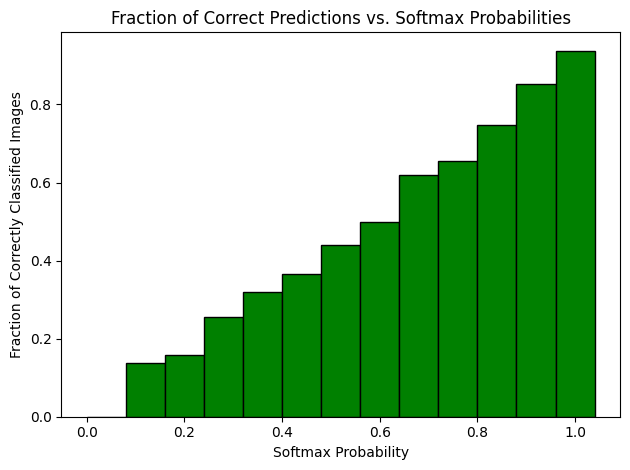

In [20]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
batch_size = 100

# Data preprocessing
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762)),
])

# CIFAR-100 dataset
test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Load the model
model = models.resnet50(pretrained=False)  # pretrained=False as you are loading trained weights
model.fc = torch.nn.Linear(model.fc.in_features, 100)  # CIFAR-100 has 100 classes
model.load_state_dict(torch.load('/kaggle/input/resnet50_10epoch_cifar100/pytorch/default/1/resnet50_10epoch_cifar100.pth', map_location=device))

# Move the model to the appropriate device
model = model.to(device)
model.eval()

# Prepare to store results
prob_bins = np.arange(0, 1.1, 0.08)  # Bins for softmax probabilities (0.0 to 1.0 in intervals of 0.08)
correct_count = np.zeros(len(prob_bins) - 1)  # Array to hold correct predictions count for each bin
incorrect_count = np.zeros(len(prob_bins) - 1)
total_count = np.zeros(len(prob_bins) - 1)  # Array to hold the total number of images per bin

# Initialize counters for accuracy
correct = 0
incorrect = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Get model outputs and softmax probabilities
        outputs = model(images)
        softmax_probs = F.softmax(outputs, dim=1)
        
        # Get predicted classes and their associated probabilities
        predicted_probs, predicted_labels = torch.max(softmax_probs, dim=1)

        # Check which predictions are correct
        correct_predictions = (predicted_labels == labels)
        incorrect_predictions = (predicted_labels != labels)
        
        # Update the accuracy counters
        total += labels.size(0)
        correct += correct_predictions.sum().item()
        incorrect += incorrect_predictions.sum().item()

        # Iterate over each image in the batch
        for i in range(images.size(0)):
            prob = predicted_probs[i].item()
            is_correct = correct_predictions[i].item()
            is_incorrect = incorrect_predictions[i].item()

            # Find which bin the probability belongs to
            bin_idx = np.digitize(prob, prob_bins) - 1  # Adjust for 0-indexing

            # Ensure bin index is within valid range
            bin_idx = min(bin_idx, len(total_count) - 1)

            # Increment the total count for the bin
            total_count[bin_idx] += 1

            # Increment correct/incorrect counts based on prediction
            if is_correct:
                correct_count[bin_idx] += 1
            if is_incorrect:
                incorrect_count[bin_idx] += 1

# Calculate accuracy per bin (fraction of correct predictions in each bin)
fraction_correct = correct_count / total_count
fraction_correct[np.isnan(fraction_correct)] = 0  # Handle division by zero

# Calculate and print overall accuracy
accuracy = 100 * correct / total
print(f'Accuracy of resnet50_cifar100 on the 10000 test images: {accuracy:.2f}%')

# Print number of images in each bin and number of correctly classified images in each bin
for i in range(len(total_count)):
    print(f'Bin {i+1} (range: {prob_bins[i]:.2f}-{prob_bins[i+1]:.2f}):')
    print(f'  Total images: {total_count[i]}')
    print(f'  Correctly classified: {correct_count[i]}')

# Plotting the results
bin_centers = 0.5 * (prob_bins[:-1] + prob_bins[1:])  # Calculate bin centers for plotting
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# First subplot for fraction of correct classifications
plt.bar(bin_centers, fraction_correct, width=0.08, color='g', edgecolor='black')
plt.xlabel('Softmax Probability')
plt.ylabel('Fraction of Correctly Classified Images')
plt.title('Fraction of Correct Predictions vs. Softmax Probabilities')

# Second subplot for total number of images per bin
# plt.set_xlabel('Softmax Probability')
# plt.set_ylabel('Number of Images')
# plt.set_title('Total Number of Images per Softmax Probability Bin')

# Display the plots
plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Total Number of Images')

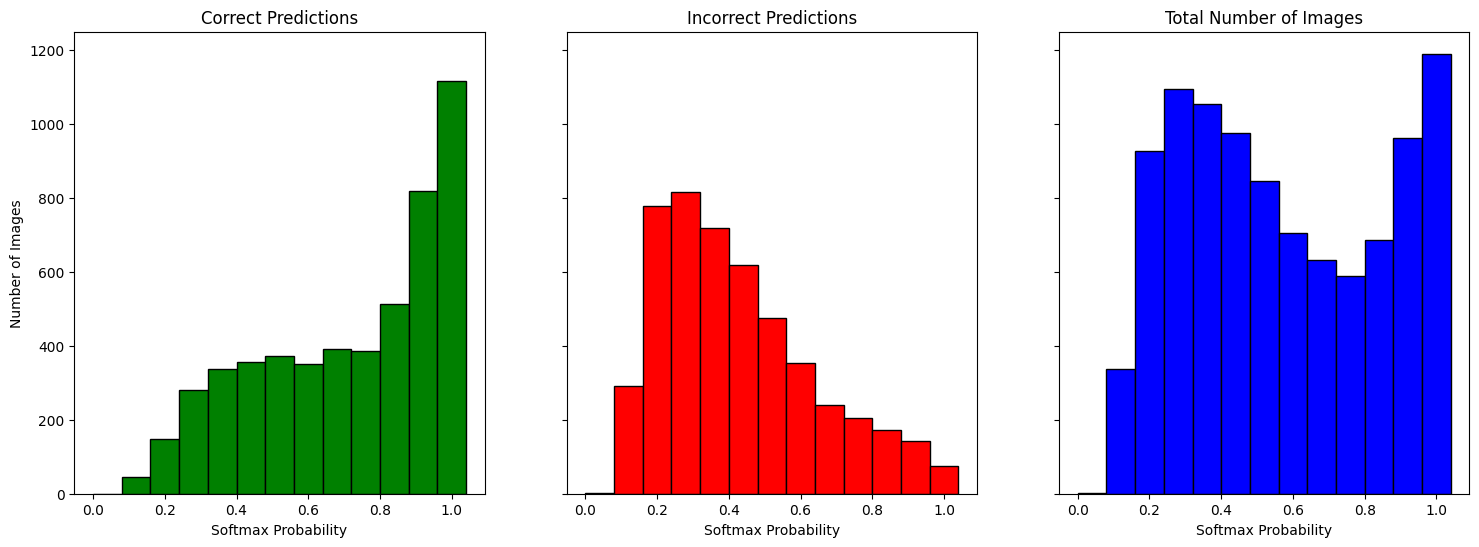

In [21]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# First subplot for the number of correct classifications
ax1.bar(bin_centers, correct_count, width=0.08, color='g', edgecolor='black')
ax1.set_xlabel('Softmax Probability')
ax1.set_ylabel('Number of Images')
ax1.set_title('Correct Predictions')

# Second subplot for the number of incorrect classifications
ax2.bar(bin_centers, incorrect_count, width=0.08, color='r', edgecolor='black')
ax2.set_xlabel('Softmax Probability')
ax2.set_title('Incorrect Predictions')

# Third subplot for the total number of images per bin
ax3.bar(bin_centers, total_count, width=0.08, color='b', edgecolor='black')
ax3.set_xlabel('Softmax Probability')
ax3.set_title('Total Number of Images')

Files already downloaded and verified
Accuracy of resnet50_cifar100 on the 10000 test images: 51.15%
Bin 1 (range: 0.00-0.02):
  Total images: 0.0
  Correctly classified: 0.0
Bin 2 (range: 0.02-0.04):
  Total images: 0.0
  Correctly classified: 0.0
Bin 3 (range: 0.04-0.06):
  Total images: 0.0
  Correctly classified: 0.0
Bin 4 (range: 0.06-0.08):
  Total images: 3.0
  Correctly classified: 0.0
Bin 5 (range: 0.08-0.10):
  Total images: 26.0
  Correctly classified: 4.0
Bin 6 (range: 0.10-0.12):
  Total images: 63.0
  Correctly classified: 4.0
Bin 7 (range: 0.12-0.14):
  Total images: 94.0
  Correctly classified: 16.0
Bin 8 (range: 0.14-0.16):
  Total images: 154.0
  Correctly classified: 22.0
Bin 9 (range: 0.16-0.18):
  Total images: 202.0
  Correctly classified: 32.0
Bin 10 (range: 0.18-0.20):
  Total images: 221.0
  Correctly classified: 25.0
Bin 11 (range: 0.20-0.22):
  Total images: 243.0
  Correctly classified: 41.0
Bin 12 (range: 0.22-0.24):
  Total images: 260.0
  Correctly classi

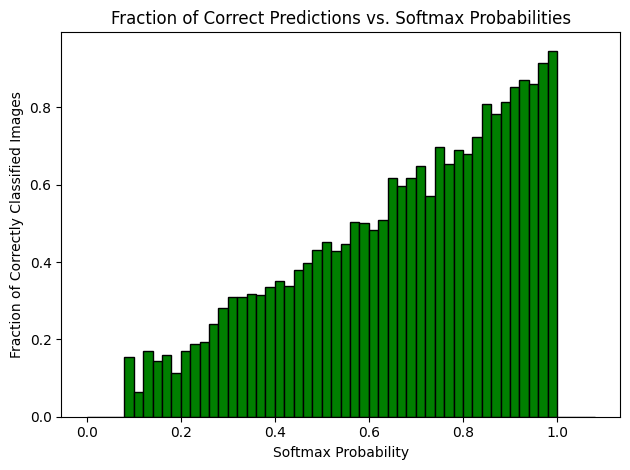

In [29]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
batch_size = 100

# Data preprocessing
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762)),
])

# CIFAR-100 dataset
test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Load the model
model = models.resnet50(pretrained=False)  # pretrained=False as you are loading trained weights
model.fc = torch.nn.Linear(model.fc.in_features, 100)  # CIFAR-100 has 100 classes
model.load_state_dict(torch.load('/kaggle/input/resnet50_10epoch_cifar100/pytorch/default/1/resnet50_10epoch_cifar100.pth', map_location=device))

# Move the model to the appropriate device
model = model.to(device)
model.eval()

# Prepare to store results
prob_bins = np.arange(0, 1.1, 0.02)  # Bins for softmax probabilities (0.0 to 1.0 in intervals of 0.08)
correct_count = np.zeros(len(prob_bins) - 1)  # Array to hold correct predictions count for each bin
incorrect_count = np.zeros(len(prob_bins) - 1)
total_count = np.zeros(len(prob_bins) - 1)  # Array to hold the total number of images per bin

# Initialize counters for accuracy
correct = 0
incorrect = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Get model outputs and softmax probabilities
        outputs = model(images)
        softmax_probs = F.softmax(outputs, dim=1)
        
        # Get predicted classes and their associated probabilities
        predicted_probs, predicted_labels = torch.max(softmax_probs, dim=1)

        # Check which predictions are correct
        correct_predictions = (predicted_labels == labels)
        incorrect_predictions = (predicted_labels != labels)
        
        # Update the accuracy counters
        total += labels.size(0)
        correct += correct_predictions.sum().item()
        incorrect += incorrect_predictions.sum().item()

        # Iterate over each image in the batch
        for i in range(images.size(0)):
            prob = predicted_probs[i].item()
            is_correct = correct_predictions[i].item()
            is_incorrect = incorrect_predictions[i].item()

            # Find which bin the probability belongs to
            bin_idx = np.digitize(prob, prob_bins) - 1  # Adjust for 0-indexing

            # Ensure bin index is within valid range
            bin_idx = min(bin_idx, len(total_count) - 1)

            # Increment the total count for the bin
            total_count[bin_idx] += 1

            # Increment correct/incorrect counts based on prediction
            if is_correct:
                correct_count[bin_idx] += 1
            if is_incorrect:
                incorrect_count[bin_idx] += 1

# Calculate accuracy per bin (fraction of correct predictions in each bin)
fraction_correct = correct_count / total_count
fraction_correct[np.isnan(fraction_correct)] = 0  # Handle division by zero

# Calculate and print overall accuracy
accuracy = 100 * correct / total
print(f'Accuracy of resnet50_cifar100 on the 10000 test images: {accuracy:.2f}%')

# Print number of images in each bin and number of correctly classified images in each bin
for i in range(len(total_count)):
    print(f'Bin {i+1} (range: {prob_bins[i]:.2f}-{prob_bins[i+1]:.2f}):')
    print(f'  Total images: {total_count[i]}')
    print(f'  Correctly classified: {correct_count[i]}')

# Plotting the results
bin_centers = 0.5 * (prob_bins[:-1] + prob_bins[1:])  # Calculate bin centers for plotting
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# First subplot for fraction of correct classifications
plt.bar(bin_centers, fraction_correct, width=0.02, color='g', edgecolor='black')
plt.xlabel('Softmax Probability')
plt.ylabel('Fraction of Correctly Classified Images')
plt.title('Fraction of Correct Predictions vs. Softmax Probabilities')

# Second subplot for total number of images per bin
# plt.set_xlabel('Softmax Probability')
# plt.set_ylabel('Number of Images')
# plt.set_title('Total Number of Images per Softmax Probability Bin')

# Display the plots
plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Total Number of Images')

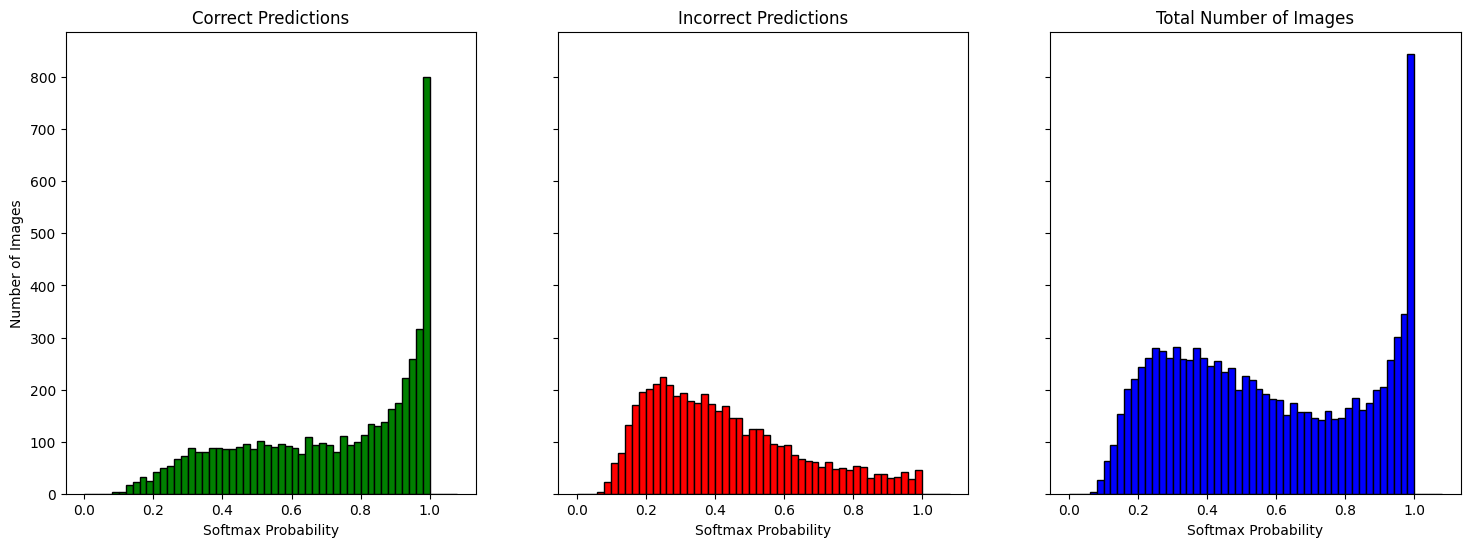

In [30]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# First subplot for the number of correct classifications
ax1.bar(bin_centers, correct_count, width=0.02, color='g', edgecolor='black')
ax1.set_xlabel('Softmax Probability')
ax1.set_ylabel('Number of Images')
ax1.set_title('Correct Predictions')

# Second subplot for the number of incorrect classifications
ax2.bar(bin_centers, incorrect_count, width=0.02, color='r', edgecolor='black')
ax2.set_xlabel('Softmax Probability')
ax2.set_title('Incorrect Predictions')

# Third subplot for the total number of images per bin
ax3.bar(bin_centers, total_count, width=0.02, color='b', edgecolor='black')
ax3.set_xlabel('Softmax Probability')
ax3.set_title('Total Number of Images')

Accuracy of resnet101_imagenet on the 10000 test images: 75.94%
Bin 1 (range: 0.00-0.02):
  Total images: 0.0
  Correctly classified: 0.0
Bin 2 (range: 0.02-0.04):
  Total images: 0.0
  Correctly classified: 0.0
Bin 3 (range: 0.04-0.06):
  Total images: 2.0
  Correctly classified: 0.0
Bin 4 (range: 0.06-0.08):
  Total images: 1.0
  Correctly classified: 0.0
Bin 5 (range: 0.08-0.10):
  Total images: 6.0
  Correctly classified: 1.0
Bin 6 (range: 0.10-0.12):
  Total images: 5.0
  Correctly classified: 2.0
Bin 7 (range: 0.12-0.14):
  Total images: 9.0
  Correctly classified: 1.0
Bin 8 (range: 0.14-0.16):
  Total images: 14.0
  Correctly classified: 0.0
Bin 9 (range: 0.16-0.18):
  Total images: 17.0
  Correctly classified: 0.0
Bin 10 (range: 0.18-0.20):
  Total images: 20.0
  Correctly classified: 4.0
Bin 11 (range: 0.20-0.22):
  Total images: 19.0
  Correctly classified: 4.0
Bin 12 (range: 0.22-0.24):
  Total images: 19.0
  Correctly classified: 3.0
Bin 13 (range: 0.24-0.26):
  Total image

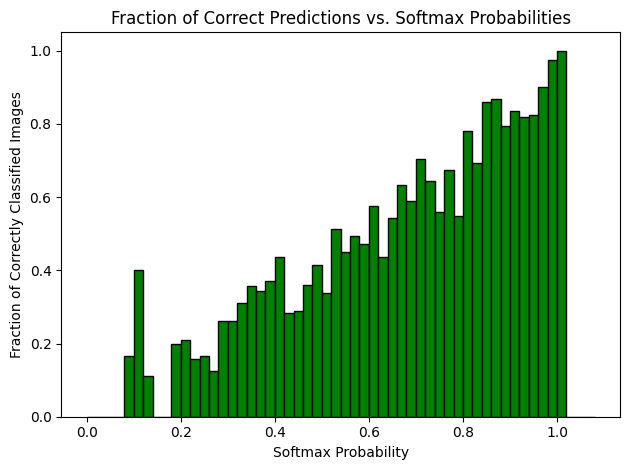

In [35]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
num_epochs = 5  # Fine-tuning for a few epochs
learning_rate = 0.001
batch_size = 100

transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_dataset = torchvision.datasets.ImageFolder(root='/kaggle/input/imagenetmini-1000/imagenet-mini/val', transform=transform_test)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

model = models.resnet101(pretrained=True)  # Use pretrained weights on ImageNet-1k

model = model.to(device)

model.eval()

prob_bins = np.arange(0, 1.1, 0.02)  # Bins for softmax probabilities (0.0 to 1.0 in intervals of 0.08)
correct_count = np.zeros(len(prob_bins) - 1)  # Array to hold correct predictions count for each bin
incorrect_count = np.zeros(len(prob_bins) - 1)
total_count = np.zeros(len(prob_bins) - 1)  # Array to hold the total number of images per bin

# Initialize counters for accuracy
correct = 0
incorrect = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Get model outputs and softmax probabilities
        outputs = model(images)
        softmax_probs = F.softmax(outputs, dim=1)
        
        # Get predicted classes and their associated probabilities
        predicted_probs, predicted_labels = torch.max(softmax_probs, dim=1)

        # Check which predictions are correct
        correct_predictions = (predicted_labels == labels)
        incorrect_predictions = (predicted_labels != labels)
        
        # Update the accuracy counters
        total += labels.size(0)
        correct += correct_predictions.sum().item()
        incorrect += incorrect_predictions.sum().item()

        # Iterate over each image in the batch
        for i in range(images.size(0)):
            prob = predicted_probs[i].item()
            is_correct = correct_predictions[i].item()
            is_incorrect = incorrect_predictions[i].item()

            # Find which bin the probability belongs to
            bin_idx = np.digitize(prob, prob_bins) - 1  # Adjust for 0-indexing

            # Ensure bin index is within valid range
            bin_idx = min(bin_idx, len(total_count) - 1)

            # Increment the total count for the bin
            total_count[bin_idx] += 1

            # Increment correct/incorrect counts based on prediction
            if is_correct:
                correct_count[bin_idx] += 1
            if is_incorrect:
                incorrect_count[bin_idx] += 1

# Calculate accuracy per bin (fraction of correct predictions in each bin)
fraction_correct = correct_count / total_count
fraction_correct[np.isnan(fraction_correct)] = 0  # Handle division by zero

# Calculate and print overall accuracy
accuracy = 100 * correct / total
print(f'Accuracy of resnet101_imagenet on the 10000 test images: {accuracy:.2f}%')

# Print number of images in each bin and number of correctly classified images in each bin
for i in range(len(total_count)):
    print(f'Bin {i+1} (range: {prob_bins[i]:.2f}-{prob_bins[i+1]:.2f}):')
    print(f'  Total images: {total_count[i]}')
    print(f'  Correctly classified: {correct_count[i]}')

# Plotting the results
bin_centers = 0.5 * (prob_bins[:-1] + prob_bins[1:])  # Calculate bin centers for plotting
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# First subplot for fraction of correct classifications
plt.bar(bin_centers, fraction_correct, width=0.02, color='g', edgecolor='black')
plt.xlabel('Softmax Probability')
plt.ylabel('Fraction of Correctly Classified Images')
plt.title('Fraction of Correct Predictions vs. Softmax Probabilities')

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Total Number of Images')

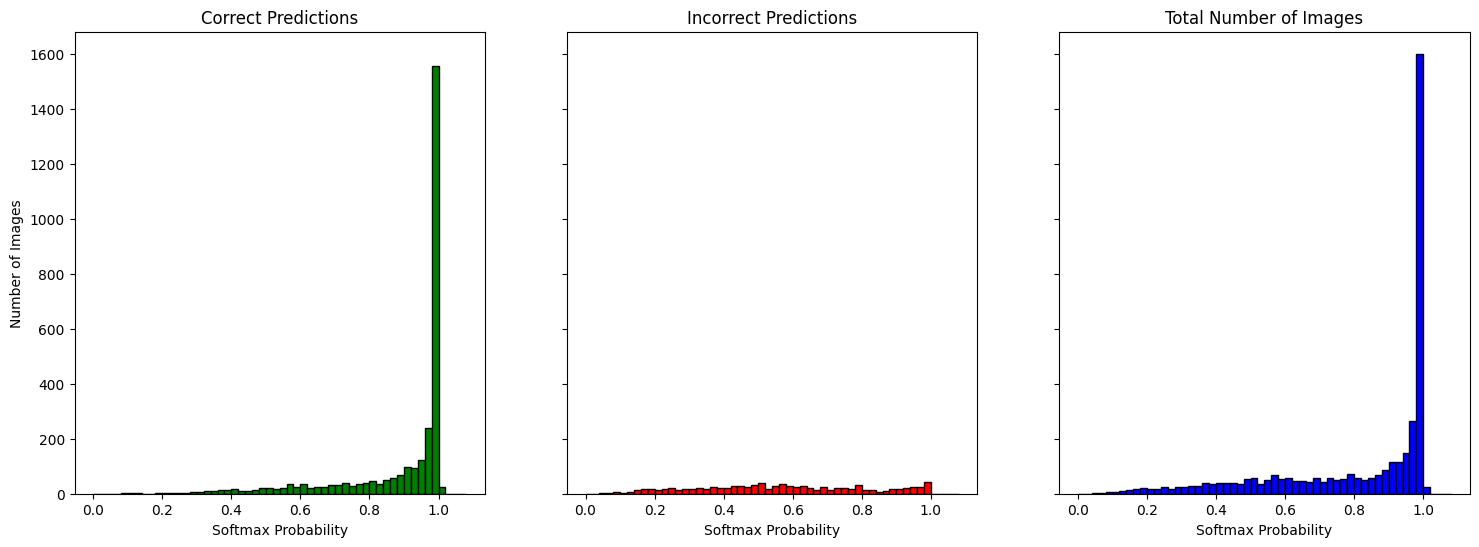

In [36]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# First subplot for the number of correct classifications
ax1.bar(bin_centers, correct_count, width=0.02, color='g', edgecolor='black')
ax1.set_xlabel('Softmax Probability')
ax1.set_ylabel('Number of Images')
ax1.set_title('Correct Predictions')

# Second subplot for the number of incorrect classifications
ax2.bar(bin_centers, incorrect_count, width=0.02, color='r', edgecolor='black')
ax2.set_xlabel('Softmax Probability')
ax2.set_title('Incorrect Predictions')

# Third subplot for the total number of images per bin
ax3.bar(bin_centers, total_count, width=0.02, color='b', edgecolor='black')
ax3.set_xlabel('Softmax Probability')
ax3.set_title('Total Number of Images')

Accuracy of resnet101_imagenet on the 10000 test images: 75.94%
Bin 1 (range: 0.00-0.08):
  Total images: 3.0
  Correctly classified: 0.0
Bin 2 (range: 0.08-0.16):
  Total images: 34.0
  Correctly classified: 4.0
Bin 3 (range: 0.16-0.24):
  Total images: 75.0
  Correctly classified: 11.0
Bin 4 (range: 0.24-0.32):
  Total images: 86.0
  Correctly classified: 18.0
Bin 5 (range: 0.32-0.40):
  Total images: 130.0
  Correctly classified: 45.0
Bin 6 (range: 0.40-0.48):
  Total images: 152.0
  Correctly classified: 52.0
Bin 7 (range: 0.48-0.56):
  Total images: 198.0
  Correctly classified: 83.0
Bin 8 (range: 0.56-0.64):
  Total images: 231.0
  Correctly classified: 115.0
Bin 9 (range: 0.64-0.72):
  Total images: 187.0
  Correctly classified: 115.0
Bin 10 (range: 0.72-0.80):
  Total images: 234.0
  Correctly classified: 141.0
Bin 11 (range: 0.80-0.88):
  Total images: 233.0
  Correctly classified: 188.0
Bin 12 (range: 0.88-0.96):
  Total images: 467.0
  Correctly classified: 383.0
Bin 13 (ran

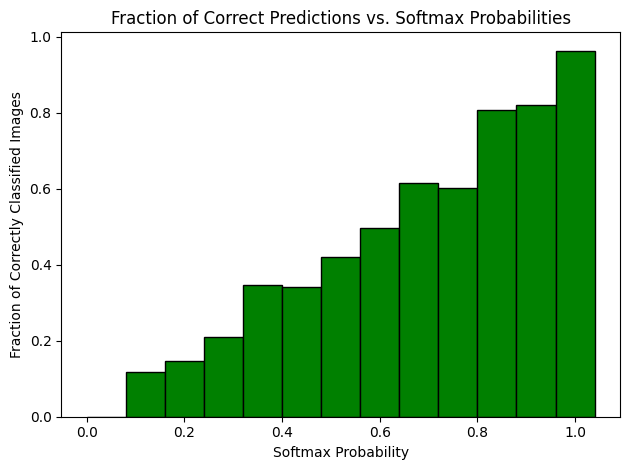

In [38]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
num_epochs = 5  # Fine-tuning for a few epochs
learning_rate = 0.001
batch_size = 100

transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_dataset = torchvision.datasets.ImageFolder(root='/kaggle/input/imagenetmini-1000/imagenet-mini/val', transform=transform_test)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

model = models.resnet101(pretrained=True)  # Use pretrained weights on ImageNet-1k

model = model.to(device)

model.eval()

prob_bins = np.arange(0, 1.1, 0.08)  # Bins for softmax probabilities (0.0 to 1.0 in intervals of 0.08)
correct_count = np.zeros(len(prob_bins) - 1)  # Array to hold correct predictions count for each bin
incorrect_count = np.zeros(len(prob_bins) - 1)
total_count = np.zeros(len(prob_bins) - 1)  # Array to hold the total number of images per bin

# Initialize counters for accuracy
correct = 0
incorrect = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Get model outputs and softmax probabilities
        outputs = model(images)
        softmax_probs = F.softmax(outputs, dim=1)
        
        # Get predicted classes and their associated probabilities
        predicted_probs, predicted_labels = torch.max(softmax_probs, dim=1)

        # Check which predictions are correct
        correct_predictions = (predicted_labels == labels)
        incorrect_predictions = (predicted_labels != labels)
        
        # Update the accuracy counters
        total += labels.size(0)
        correct += correct_predictions.sum().item()
        incorrect += incorrect_predictions.sum().item()

        # Iterate over each image in the batch
        for i in range(images.size(0)):
            prob = predicted_probs[i].item()
            is_correct = correct_predictions[i].item()
            is_incorrect = incorrect_predictions[i].item()

            # Find which bin the probability belongs to
            bin_idx = np.digitize(prob, prob_bins) - 1  # Adjust for 0-indexing

            # Ensure bin index is within valid range
            bin_idx = min(bin_idx, len(total_count) - 1)

            # Increment the total count for the bin
            total_count[bin_idx] += 1

            # Increment correct/incorrect counts based on prediction
            if is_correct:
                correct_count[bin_idx] += 1
            if is_incorrect:
                incorrect_count[bin_idx] += 1

# Calculate accuracy per bin (fraction of correct predictions in each bin)
fraction_correct = correct_count / total_count
fraction_correct[np.isnan(fraction_correct)] = 0  # Handle division by zero

# Calculate and print overall accuracy
accuracy = 100 * correct / total
print(f'Accuracy of resnet101_imagenet on the 10000 test images: {accuracy:.2f}%')

# Print number of images in each bin and number of correctly classified images in each bin
for i in range(len(total_count)):
    print(f'Bin {i+1} (range: {prob_bins[i]:.2f}-{prob_bins[i+1]:.2f}):')
    print(f'  Total images: {total_count[i]}')
    print(f'  Correctly classified: {correct_count[i]}')

# Plotting the results
bin_centers = 0.5 * (prob_bins[:-1] + prob_bins[1:])  # Calculate bin centers for plotting
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# First subplot for fraction of correct classifications
plt.bar(bin_centers, fraction_correct, width=0.08, color='g', edgecolor='black')
plt.xlabel('Softmax Probability')
plt.ylabel('Fraction of Correctly Classified Images')
plt.title('Fraction of Correct Predictions vs. Softmax Probabilities')

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Total Number of Images')

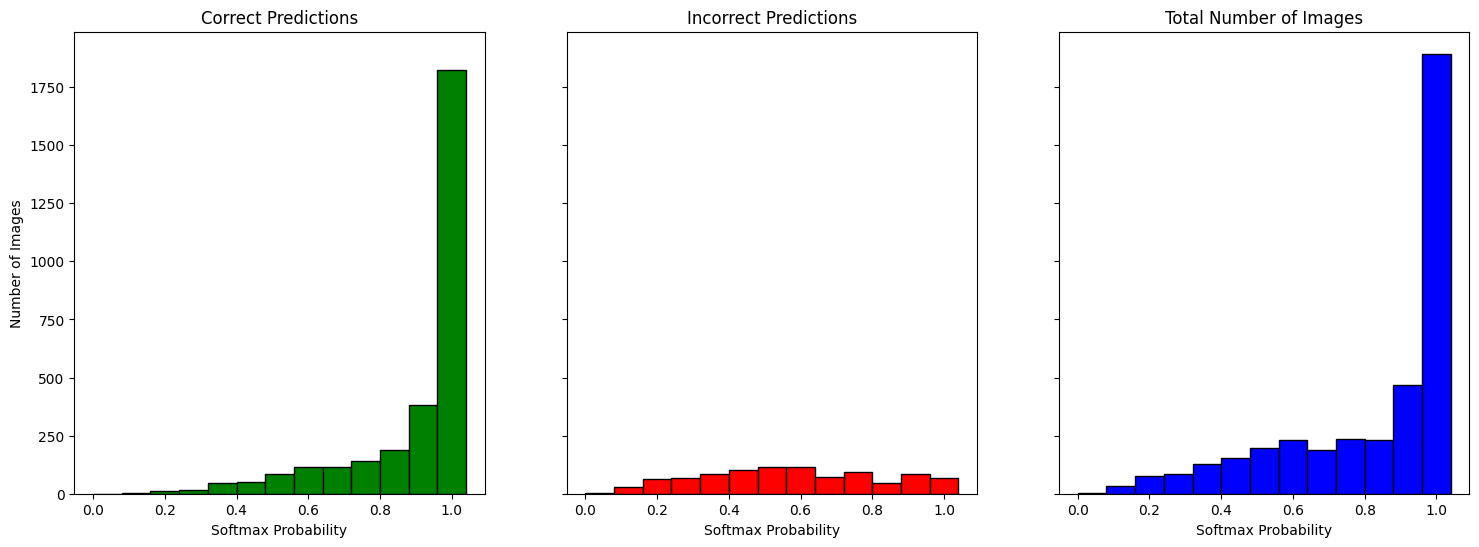

In [39]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# First subplot for the number of correct classifications
ax1.bar(bin_centers, correct_count, width=0.08, color='g', edgecolor='black')
ax1.set_xlabel('Softmax Probability')
ax1.set_ylabel('Number of Images')
ax1.set_title('Correct Predictions')

# Second subplot for the number of incorrect classifications
ax2.bar(bin_centers, incorrect_count, width=0.08, color='r', edgecolor='black')
ax2.set_xlabel('Softmax Probability')
ax2.set_title('Incorrect Predictions')

# Third subplot for the total number of images per bin
ax3.bar(bin_centers, total_count, width=0.08, color='b', edgecolor='black')
ax3.set_xlabel('Softmax Probability')
ax3.set_title('Total Number of Images')

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 183MB/s] 


Accuracy of resnet50_imagenet on the 10000 test images: 75.71%
Bin 1 (range: 0.00-0.02):
  Total images: 0.0
  Correctly classified: 0.0
Bin 2 (range: 0.02-0.04):
  Total images: 0.0
  Correctly classified: 0.0
Bin 3 (range: 0.04-0.06):
  Total images: 1.0
  Correctly classified: 0.0
Bin 4 (range: 0.06-0.08):
  Total images: 2.0
  Correctly classified: 0.0
Bin 5 (range: 0.08-0.10):
  Total images: 7.0
  Correctly classified: 0.0
Bin 6 (range: 0.10-0.12):
  Total images: 8.0
  Correctly classified: 2.0
Bin 7 (range: 0.12-0.14):
  Total images: 9.0
  Correctly classified: 3.0
Bin 8 (range: 0.14-0.16):
  Total images: 18.0
  Correctly classified: 4.0
Bin 9 (range: 0.16-0.18):
  Total images: 22.0
  Correctly classified: 4.0
Bin 10 (range: 0.18-0.20):
  Total images: 20.0
  Correctly classified: 4.0
Bin 11 (range: 0.20-0.22):
  Total images: 28.0
  Correctly classified: 4.0
Bin 12 (range: 0.22-0.24):
  Total images: 24.0
  Correctly classified: 7.0
Bin 13 (range: 0.24-0.26):
  Total images

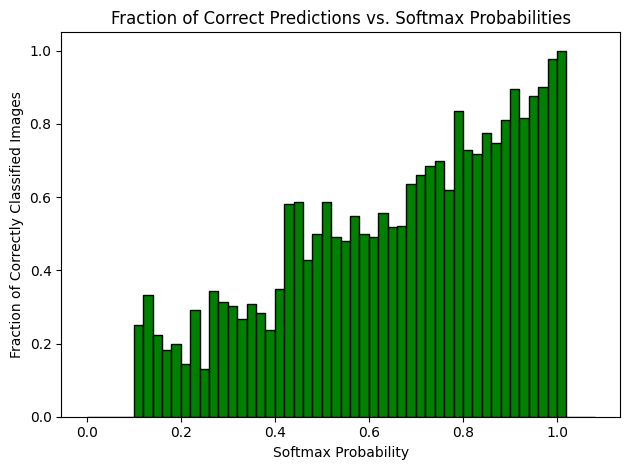

In [40]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
num_epochs = 5  # Fine-tuning for a few epochs
learning_rate = 0.001
batch_size = 100

transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_dataset = torchvision.datasets.ImageFolder(root='/kaggle/input/imagenetmini-1000/imagenet-mini/val', transform=transform_test)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

model = models.resnet50(pretrained=True)  # Use pretrained weights on ImageNet-1k

model = model.to(device)

model.eval()

prob_bins = np.arange(0, 1.1, 0.02)  # Bins for softmax probabilities (0.0 to 1.0 in intervals of 0.08)
correct_count = np.zeros(len(prob_bins) - 1)  # Array to hold correct predictions count for each bin
incorrect_count = np.zeros(len(prob_bins) - 1)
total_count = np.zeros(len(prob_bins) - 1)  # Array to hold the total number of images per bin

# Initialize counters for accuracy
correct = 0
incorrect = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Get model outputs and softmax probabilities
        outputs = model(images)
        softmax_probs = F.softmax(outputs, dim=1)
        
        # Get predicted classes and their associated probabilities
        predicted_probs, predicted_labels = torch.max(softmax_probs, dim=1)

        # Check which predictions are correct
        correct_predictions = (predicted_labels == labels)
        incorrect_predictions = (predicted_labels != labels)
        
        # Update the accuracy counters
        total += labels.size(0)
        correct += correct_predictions.sum().item()
        incorrect += incorrect_predictions.sum().item()

        # Iterate over each image in the batch
        for i in range(images.size(0)):
            prob = predicted_probs[i].item()
            is_correct = correct_predictions[i].item()
            is_incorrect = incorrect_predictions[i].item()

            # Find which bin the probability belongs to
            bin_idx = np.digitize(prob, prob_bins) - 1  # Adjust for 0-indexing

            # Ensure bin index is within valid range
            bin_idx = min(bin_idx, len(total_count) - 1)

            # Increment the total count for the bin
            total_count[bin_idx] += 1

            # Increment correct/incorrect counts based on prediction
            if is_correct:
                correct_count[bin_idx] += 1
            if is_incorrect:
                incorrect_count[bin_idx] += 1

# Calculate accuracy per bin (fraction of correct predictions in each bin)
fraction_correct = correct_count / total_count
fraction_correct[np.isnan(fraction_correct)] = 0  # Handle division by zero

# Calculate and print overall accuracy
accuracy = 100 * correct / total
print(f'Accuracy of resnet50_imagenet on the 10000 test images: {accuracy:.2f}%')

# Print number of images in each bin and number of correctly classified images in each bin
for i in range(len(total_count)):
    print(f'Bin {i+1} (range: {prob_bins[i]:.2f}-{prob_bins[i+1]:.2f}):')
    print(f'  Total images: {total_count[i]}')
    print(f'  Correctly classified: {correct_count[i]}')

# Plotting the results
bin_centers = 0.5 * (prob_bins[:-1] + prob_bins[1:])  # Calculate bin centers for plotting
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# First subplot for fraction of correct classifications
plt.bar(bin_centers, fraction_correct, width=0.02, color='g', edgecolor='black')
plt.xlabel('Softmax Probability')
plt.ylabel('Fraction of Correctly Classified Images')
plt.title('Fraction of Correct Predictions vs. Softmax Probabilities')

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Total Number of Images')

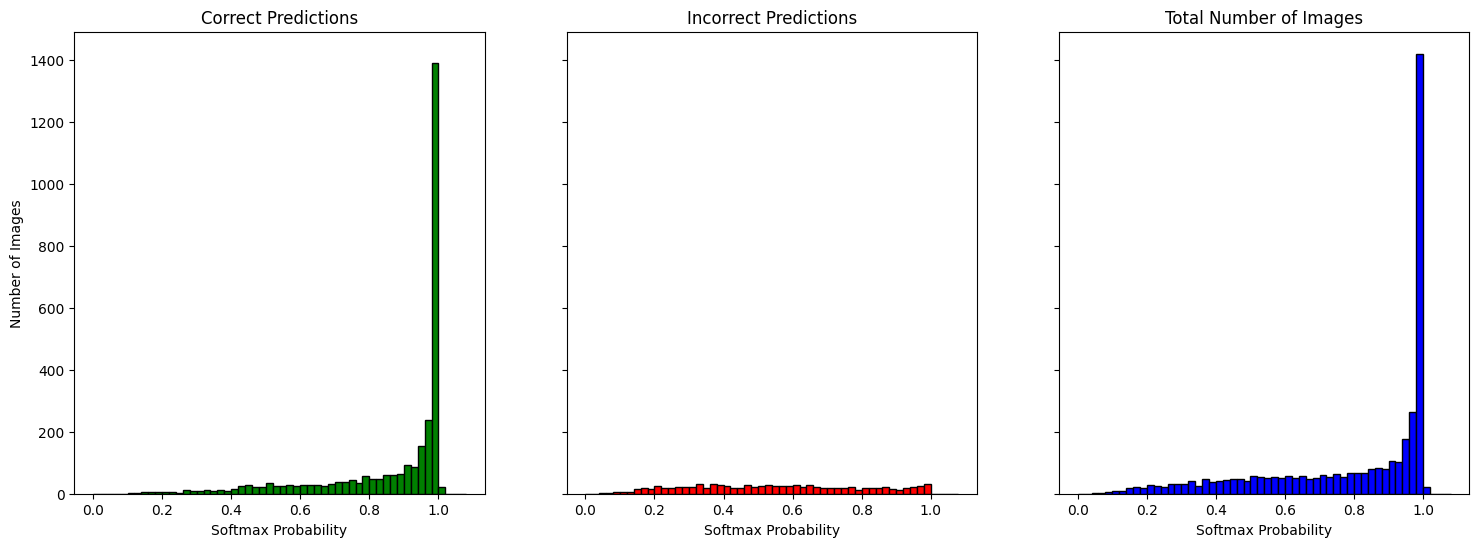

In [41]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# First subplot for the number of correct classifications
ax1.bar(bin_centers, correct_count, width=0.02, color='g', edgecolor='black')
ax1.set_xlabel('Softmax Probability')
ax1.set_ylabel('Number of Images')
ax1.set_title('Correct Predictions')

# Second subplot for the number of incorrect classifications
ax2.bar(bin_centers, incorrect_count, width=0.02, color='r', edgecolor='black')
ax2.set_xlabel('Softmax Probability')
ax2.set_title('Incorrect Predictions')

# Third subplot for the total number of images per bin
ax3.bar(bin_centers, total_count, width=0.02, color='b', edgecolor='black')
ax3.set_xlabel('Softmax Probability')
ax3.set_title('Total Number of Images')

Accuracy of resnet50_imagenet on the 10000 test images: 75.71%
Bin 1 (range: 0.00-0.08):
  Total images: 3.0
  Correctly classified: 0.0
Bin 2 (range: 0.08-0.16):
  Total images: 42.0
  Correctly classified: 9.0
Bin 3 (range: 0.16-0.24):
  Total images: 94.0
  Correctly classified: 19.0
Bin 4 (range: 0.24-0.32):
  Total images: 120.0
  Correctly classified: 34.0
Bin 5 (range: 0.32-0.40):
  Total images: 151.0
  Correctly classified: 41.0
Bin 6 (range: 0.40-0.48):
  Total images: 178.0
  Correctly classified: 87.0
Bin 7 (range: 0.48-0.56):
  Total images: 203.0
  Correctly classified: 105.0
Bin 8 (range: 0.56-0.64):
  Total images: 212.0
  Correctly classified: 111.0
Bin 9 (range: 0.64-0.72):
  Total images: 213.0
  Correctly classified: 125.0
Bin 10 (range: 0.72-0.80):
  Total images: 239.0
  Correctly classified: 171.0
Bin 11 (range: 0.80-0.88):
  Total images: 296.0
  Correctly classified: 220.0
Bin 12 (range: 0.88-0.96):
  Total images: 464.0
  Correctly classified: 397.0
Bin 13 (ra

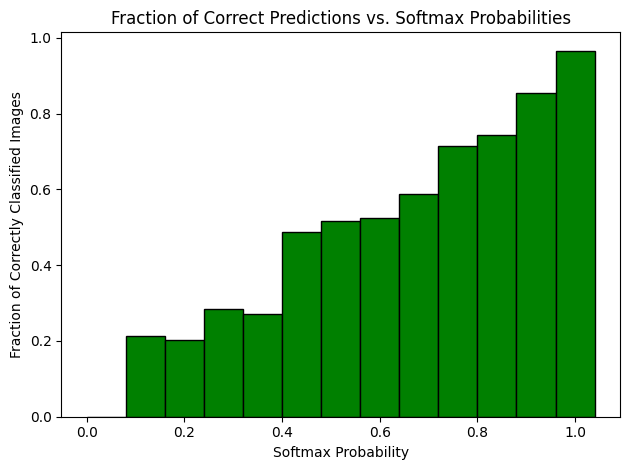

In [43]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
num_epochs = 5  # Fine-tuning for a few epochs
learning_rate = 0.001
batch_size = 100

transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_dataset = torchvision.datasets.ImageFolder(root='/kaggle/input/imagenetmini-1000/imagenet-mini/val', transform=transform_test)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

model = models.resnet50(pretrained=True)  # Use pretrained weights on ImageNet-1k

model = model.to(device)

model.eval()

prob_bins = np.arange(0, 1.1, 0.08)  # Bins for softmax probabilities (0.0 to 1.0 in intervals of 0.08)
correct_count = np.zeros(len(prob_bins) - 1)  # Array to hold correct predictions count for each bin
incorrect_count = np.zeros(len(prob_bins) - 1)
total_count = np.zeros(len(prob_bins) - 1)  # Array to hold the total number of images per bin

# Initialize counters for accuracy
correct = 0
incorrect = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Get model outputs and softmax probabilities
        outputs = model(images)
        softmax_probs = F.softmax(outputs, dim=1)
        
        # Get predicted classes and their associated probabilities
        predicted_probs, predicted_labels = torch.max(softmax_probs, dim=1)

        # Check which predictions are correct
        correct_predictions = (predicted_labels == labels)
        incorrect_predictions = (predicted_labels != labels)
        
        # Update the accuracy counters
        total += labels.size(0)
        correct += correct_predictions.sum().item()
        incorrect += incorrect_predictions.sum().item()

        # Iterate over each image in the batch
        for i in range(images.size(0)):
            prob = predicted_probs[i].item()
            is_correct = correct_predictions[i].item()
            is_incorrect = incorrect_predictions[i].item()

            # Find which bin the probability belongs to
            bin_idx = np.digitize(prob, prob_bins) - 1  # Adjust for 0-indexing

            # Ensure bin index is within valid range
            bin_idx = min(bin_idx, len(total_count) - 1)

            # Increment the total count for the bin
            total_count[bin_idx] += 1

            # Increment correct/incorrect counts based on prediction
            if is_correct:
                correct_count[bin_idx] += 1
            if is_incorrect:
                incorrect_count[bin_idx] += 1

# Calculate accuracy per bin (fraction of correct predictions in each bin)
fraction_correct = correct_count / total_count
fraction_correct[np.isnan(fraction_correct)] = 0  # Handle division by zero

# Calculate and print overall accuracy
accuracy = 100 * correct / total
print(f'Accuracy of resnet50_imagenet on the 10000 test images: {accuracy:.2f}%')

# Print number of images in each bin and number of correctly classified images in each bin
for i in range(len(total_count)):
    print(f'Bin {i+1} (range: {prob_bins[i]:.2f}-{prob_bins[i+1]:.2f}):')
    print(f'  Total images: {total_count[i]}')
    print(f'  Correctly classified: {correct_count[i]}')

# Plotting the results
bin_centers = 0.5 * (prob_bins[:-1] + prob_bins[1:])  # Calculate bin centers for plotting
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# First subplot for fraction of correct classifications
plt.bar(bin_centers, fraction_correct, width=0.08, color='g', edgecolor='black')
plt.xlabel('Softmax Probability')
plt.ylabel('Fraction of Correctly Classified Images')
plt.title('Fraction of Correct Predictions vs. Softmax Probabilities')

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Total Number of Images')

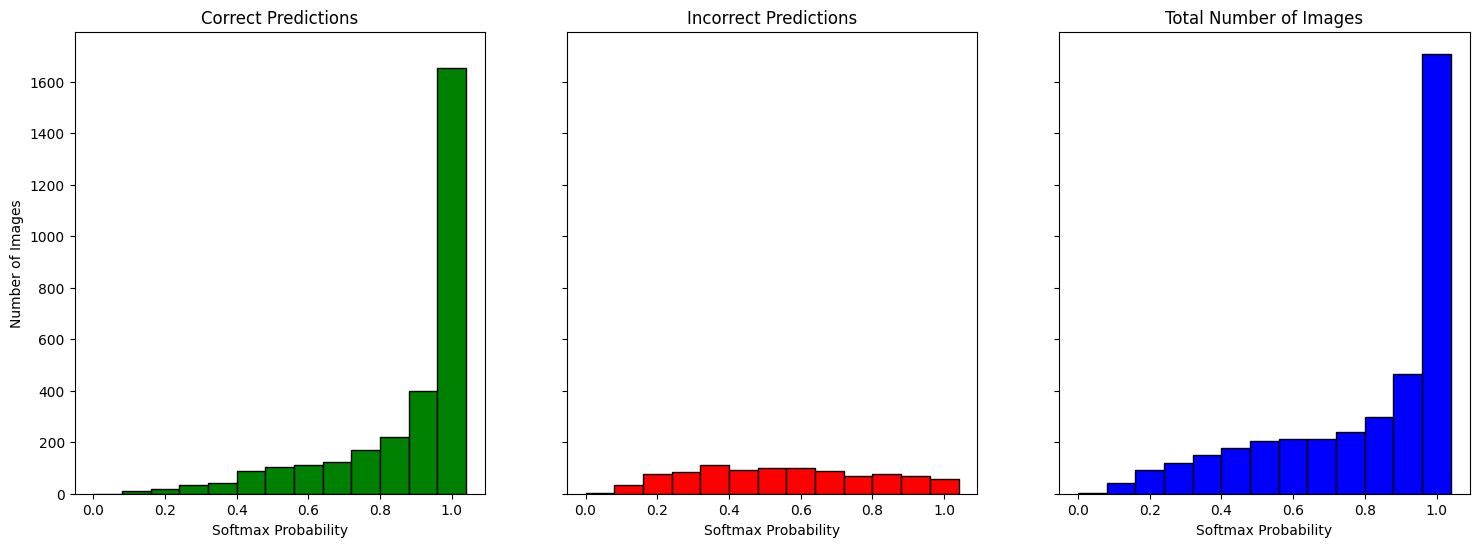

In [44]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# First subplot for the number of correct classifications
ax1.bar(bin_centers, correct_count, width=0.08, color='g', edgecolor='black')
ax1.set_xlabel('Softmax Probability')
ax1.set_ylabel('Number of Images')
ax1.set_title('Correct Predictions')

# Second subplot for the number of incorrect classifications
ax2.bar(bin_centers, incorrect_count, width=0.08, color='r', edgecolor='black')
ax2.set_xlabel('Softmax Probability')
ax2.set_title('Incorrect Predictions')

# Third subplot for the total number of images per bin
ax3.bar(bin_centers, total_count, width=0.08, color='b', edgecolor='black')
ax3.set_xlabel('Softmax Probability')
ax3.set_title('Total Number of Images')

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:01<00:00, 175MB/s]  


Accuracy of resnet152_imagenet on the 10000 test images: 76.50%
Bin 1 (range: 0.00-0.02):
  Total images: 0.0
  Correctly classified: 0.0
Bin 2 (range: 0.02-0.04):
  Total images: 0.0
  Correctly classified: 0.0
Bin 3 (range: 0.04-0.06):
  Total images: 1.0
  Correctly classified: 1.0
Bin 4 (range: 0.06-0.08):
  Total images: 2.0
  Correctly classified: 0.0
Bin 5 (range: 0.08-0.10):
  Total images: 3.0
  Correctly classified: 0.0
Bin 6 (range: 0.10-0.12):
  Total images: 4.0
  Correctly classified: 0.0
Bin 7 (range: 0.12-0.14):
  Total images: 5.0
  Correctly classified: 2.0
Bin 8 (range: 0.14-0.16):
  Total images: 10.0
  Correctly classified: 1.0
Bin 9 (range: 0.16-0.18):
  Total images: 12.0
  Correctly classified: 2.0
Bin 10 (range: 0.18-0.20):
  Total images: 17.0
  Correctly classified: 3.0
Bin 11 (range: 0.20-0.22):
  Total images: 23.0
  Correctly classified: 4.0
Bin 12 (range: 0.22-0.24):
  Total images: 15.0
  Correctly classified: 2.0
Bin 13 (range: 0.24-0.26):
  Total image

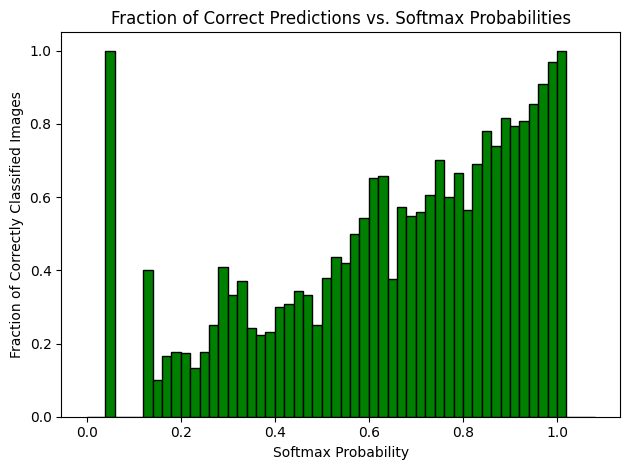

In [45]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
num_epochs = 5  # Fine-tuning for a few epochs
learning_rate = 0.001
batch_size = 100

transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_dataset = torchvision.datasets.ImageFolder(root='/kaggle/input/imagenetmini-1000/imagenet-mini/val', transform=transform_test)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

model = models.resnet152(pretrained=True)  # Use pretrained weights on ImageNet-1k

model = model.to(device)

model.eval()

prob_bins = np.arange(0, 1.1, 0.02)  # Bins for softmax probabilities (0.0 to 1.0 in intervals of 0.08)
correct_count = np.zeros(len(prob_bins) - 1)  # Array to hold correct predictions count for each bin
incorrect_count = np.zeros(len(prob_bins) - 1)
total_count = np.zeros(len(prob_bins) - 1)  # Array to hold the total number of images per bin

# Initialize counters for accuracy
correct = 0
incorrect = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Get model outputs and softmax probabilities
        outputs = model(images)
        softmax_probs = F.softmax(outputs, dim=1)
        
        # Get predicted classes and their associated probabilities
        predicted_probs, predicted_labels = torch.max(softmax_probs, dim=1)

        # Check which predictions are correct
        correct_predictions = (predicted_labels == labels)
        incorrect_predictions = (predicted_labels != labels)
        
        # Update the accuracy counters
        total += labels.size(0)
        correct += correct_predictions.sum().item()
        incorrect += incorrect_predictions.sum().item()

        # Iterate over each image in the batch
        for i in range(images.size(0)):
            prob = predicted_probs[i].item()
            is_correct = correct_predictions[i].item()
            is_incorrect = incorrect_predictions[i].item()

            # Find which bin the probability belongs to
            bin_idx = np.digitize(prob, prob_bins) - 1  # Adjust for 0-indexing

            # Ensure bin index is within valid range
            bin_idx = min(bin_idx, len(total_count) - 1)

            # Increment the total count for the bin
            total_count[bin_idx] += 1

            # Increment correct/incorrect counts based on prediction
            if is_correct:
                correct_count[bin_idx] += 1
            if is_incorrect:
                incorrect_count[bin_idx] += 1

# Calculate accuracy per bin (fraction of correct predictions in each bin)
fraction_correct = correct_count / total_count
fraction_correct[np.isnan(fraction_correct)] = 0  # Handle division by zero

# Calculate and print overall accuracy
accuracy = 100 * correct / total
print(f'Accuracy of resnet152_imagenet on the 10000 test images: {accuracy:.2f}%')

# Print number of images in each bin and number of correctly classified images in each bin
for i in range(len(total_count)):
    print(f'Bin {i+1} (range: {prob_bins[i]:.2f}-{prob_bins[i+1]:.2f}):')
    print(f'  Total images: {total_count[i]}')
    print(f'  Correctly classified: {correct_count[i]}')

# Plotting the results
bin_centers = 0.5 * (prob_bins[:-1] + prob_bins[1:])  # Calculate bin centers for plotting
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# First subplot for fraction of correct classifications
plt.bar(bin_centers, fraction_correct, width=0.02, color='g', edgecolor='black')
plt.xlabel('Softmax Probability')
plt.ylabel('Fraction of Correctly Classified Images')
plt.title('Fraction of Correct Predictions vs. Softmax Probabilities')

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Total Number of Images')

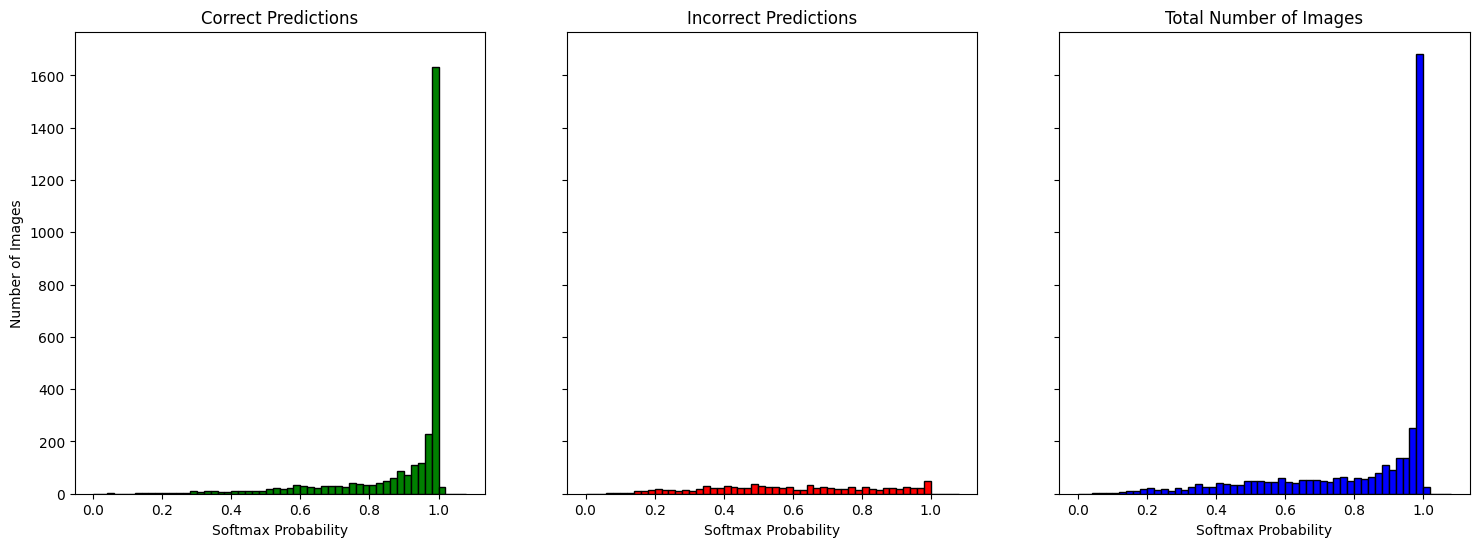

In [46]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# First subplot for the number of correct classifications
ax1.bar(bin_centers, correct_count, width=0.02, color='g', edgecolor='black')
ax1.set_xlabel('Softmax Probability')
ax1.set_ylabel('Number of Images')
ax1.set_title('Correct Predictions')

# Second subplot for the number of incorrect classifications
ax2.bar(bin_centers, incorrect_count, width=0.02, color='r', edgecolor='black')
ax2.set_xlabel('Softmax Probability')
ax2.set_title('Incorrect Predictions')

# Third subplot for the total number of images per bin
ax3.bar(bin_centers, total_count, width=0.02, color='b', edgecolor='black')
ax3.set_xlabel('Softmax Probability')
ax3.set_title('Total Number of Images')

Accuracy of resnet152_imagenet on the 10000 test images: 76.50%
Bin 1 (range: 0.00-0.08):
  Total images: 3.0
  Correctly classified: 1.0
Bin 2 (range: 0.08-0.16):
  Total images: 22.0
  Correctly classified: 3.0
Bin 3 (range: 0.16-0.24):
  Total images: 67.0
  Correctly classified: 11.0
Bin 4 (range: 0.24-0.32):
  Total images: 66.0
  Correctly classified: 20.0
Bin 5 (range: 0.32-0.40):
  Total images: 117.0
  Correctly classified: 31.0
Bin 6 (range: 0.40-0.48):
  Total images: 144.0
  Correctly classified: 46.0
Bin 7 (range: 0.48-0.56):
  Total images: 189.0
  Correctly classified: 70.0
Bin 8 (range: 0.56-0.64):
  Total images: 190.0
  Correctly classified: 111.0
Bin 9 (range: 0.64-0.72):
  Total images: 210.0
  Correctly classified: 108.0
Bin 10 (range: 0.72-0.80):
  Total images: 216.0
  Correctly classified: 139.0
Bin 11 (range: 0.80-0.88):
  Total images: 265.0
  Correctly classified: 185.0
Bin 12 (range: 0.88-0.96):
  Total images: 473.0
  Correctly classified: 388.0
Bin 13 (ran

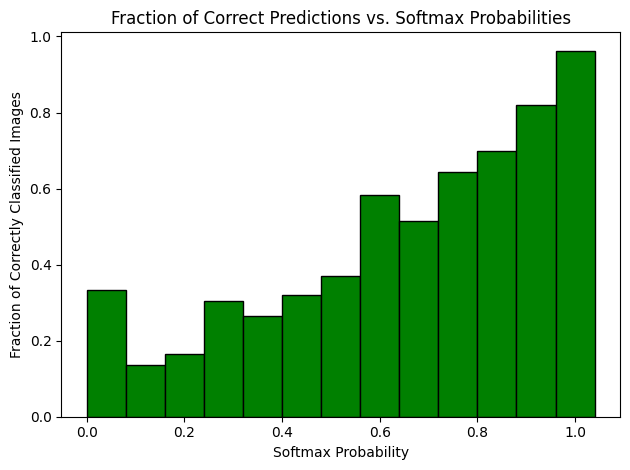

In [47]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
num_epochs = 5  # Fine-tuning for a few epochs
learning_rate = 0.001
batch_size = 100

transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_dataset = torchvision.datasets.ImageFolder(root='/kaggle/input/imagenetmini-1000/imagenet-mini/val', transform=transform_test)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

model = models.resnet152(pretrained=True)  # Use pretrained weights on ImageNet-1k

model = model.to(device)

model.eval()

prob_bins = np.arange(0, 1.1, 0.08)  # Bins for softmax probabilities (0.0 to 1.0 in intervals of 0.08)
correct_count = np.zeros(len(prob_bins) - 1)  # Array to hold correct predictions count for each bin
incorrect_count = np.zeros(len(prob_bins) - 1)
total_count = np.zeros(len(prob_bins) - 1)  # Array to hold the total number of images per bin

# Initialize counters for accuracy
correct = 0
incorrect = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Get model outputs and softmax probabilities
        outputs = model(images)
        softmax_probs = F.softmax(outputs, dim=1)
        
        # Get predicted classes and their associated probabilities
        predicted_probs, predicted_labels = torch.max(softmax_probs, dim=1)

        # Check which predictions are correct
        correct_predictions = (predicted_labels == labels)
        incorrect_predictions = (predicted_labels != labels)
        
        # Update the accuracy counters
        total += labels.size(0)
        correct += correct_predictions.sum().item()
        incorrect += incorrect_predictions.sum().item()

        # Iterate over each image in the batch
        for i in range(images.size(0)):
            prob = predicted_probs[i].item()
            is_correct = correct_predictions[i].item()
            is_incorrect = incorrect_predictions[i].item()

            # Find which bin the probability belongs to
            bin_idx = np.digitize(prob, prob_bins) - 1  # Adjust for 0-indexing

            # Ensure bin index is within valid range
            bin_idx = min(bin_idx, len(total_count) - 1)

            # Increment the total count for the bin
            total_count[bin_idx] += 1

            # Increment correct/incorrect counts based on prediction
            if is_correct:
                correct_count[bin_idx] += 1
            if is_incorrect:
                incorrect_count[bin_idx] += 1

# Calculate accuracy per bin (fraction of correct predictions in each bin)
fraction_correct = correct_count / total_count
fraction_correct[np.isnan(fraction_correct)] = 0  # Handle division by zero

# Calculate and print overall accuracy
accuracy = 100 * correct / total
print(f'Accuracy of resnet152_imagenet on the 10000 test images: {accuracy:.2f}%')

# Print number of images in each bin and number of correctly classified images in each bin
for i in range(len(total_count)):
    print(f'Bin {i+1} (range: {prob_bins[i]:.2f}-{prob_bins[i+1]:.2f}):')
    print(f'  Total images: {total_count[i]}')
    print(f'  Correctly classified: {correct_count[i]}')

# Plotting the results
bin_centers = 0.5 * (prob_bins[:-1] + prob_bins[1:])  # Calculate bin centers for plotting
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# First subplot for fraction of correct classifications
plt.bar(bin_centers, fraction_correct, width=0.08, color='g', edgecolor='black')
plt.xlabel('Softmax Probability')
plt.ylabel('Fraction of Correctly Classified Images')
plt.title('Fraction of Correct Predictions vs. Softmax Probabilities')

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Total Number of Images')

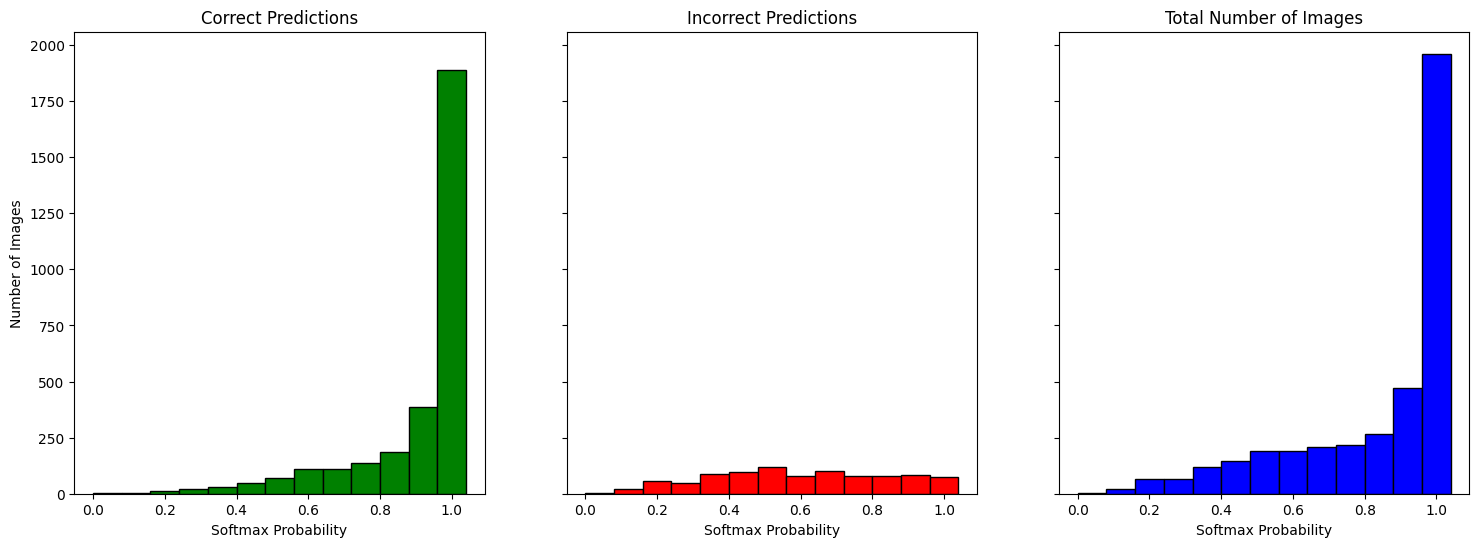

In [48]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# First subplot for the number of correct classifications
ax1.bar(bin_centers, correct_count, width=0.08, color='g', edgecolor='black')
ax1.set_xlabel('Softmax Probability')
ax1.set_ylabel('Number of Images')
ax1.set_title('Correct Predictions')

# Second subplot for the number of incorrect classifications
ax2.bar(bin_centers, incorrect_count, width=0.08, color='r', edgecolor='black')
ax2.set_xlabel('Softmax Probability')
ax2.set_title('Incorrect Predictions')

# Third subplot for the total number of images per bin
ax3.bar(bin_centers, total_count, width=0.08, color='b', edgecolor='black')
ax3.set_xlabel('Softmax Probability')
ax3.set_title('Total Number of Images')

The equation of the polynomial is: y = 6.0253x^4 + -13.5615x^3 + 10.9021x^2 + -2.7978x^1 + 0.4001


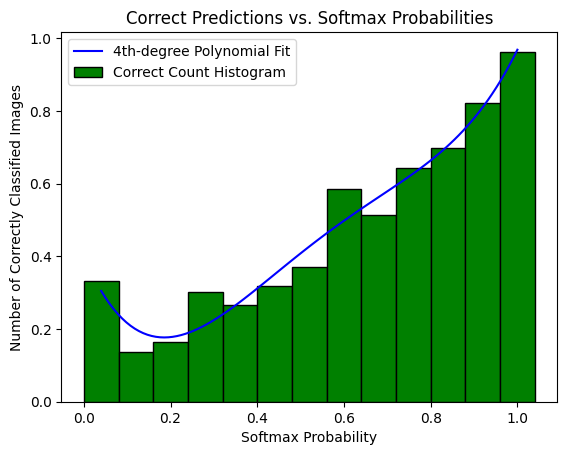

In [53]:
from numpy import polyfit, poly1d
import matplotlib.pyplot as plt

# Choose the degree of the polynomial
degree =  4 # Change this to any desired degree

# Fit a polynomial of the specified degree to the data
coefficients = polyfit(bin_centers, fraction_correct, degree)
polynomial = poly1d(coefficients)

# Generate values to plot the fitted polynomial
x_fit = np.linspace(min(bin_centers), max(bin_centers), 100)
y_fit = polynomial(x_fit)

# Print the equation of the polynomial
equation = "y = " + " + ".join([f"{coefficients[i]:.4f}x^{degree - i}" for i in range(degree)]) + f" + {coefficients[-1]:.4f}"
print(f"The equation of the polynomial is: {equation}")

# Plot the original histogram and the fitted polynomial
plt.bar(bin_centers, fraction_correct, width=0.08, color='g', edgecolor='black', label='Correct Count Histogram')
plt.plot(x_fit, y_fit, color='blue', label=f'{degree}th-degree Polynomial Fit')

plt.xlabel('Softmax Probability')
plt.ylabel('Number of Correctly Classified Images')
plt.title('Correct Predictions vs. Softmax Probabilities')
plt.legend()
plt.show()


https://www.kaggle.com/code/krazy47/cifar100-best-trained-model-resnet18-pretrained

https://github.com/chenyaofo/pytorch-cifar-models?tab=readme-ov-file

https://github.com/weiaicunzai/pytorch-cifar100

https://huggingface.co/edadaltocg/resnet18_cifar100

https://paperswithcode.com/sota/image-classification-on-cifar-100

https://github.com/openvinotoolkit/open_model_zoo/blob/master/demos/classification_demo/python/README.md

https://github.com/abhinav-neil/resnet-transfer-learning/blob/main/Readme.md

https://github.com/Jasonlee1995/ImageNet-1K/tree/main